## Modeling lobbying and stock trading jointly

The goal of this notebook is to propose a number of different models that jointly consider lobbying and stock trading. We will:
1. Fix a few baseline models, and see how they perform.
2. Choose a number of more complicated models, and explain the hyperparameter restrictions/sharing conditions we are imposing.
3. Model selection. In doing so, we will keep track of cross-validation error to try to minimize overfitting.
4. Identify our best choice, evaluate its performance, and try to improve it further.

First, let's import the basics here.

In [1]:
import numpy as np
import pandas as pd
import datetime
import ast
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
sns.set_theme()
from importlib import reload
import torch

# Silencing warnings 
import warnings
warnings.filterwarnings("ignore")

In [2]:
import scripts.data_extraction
reload(scripts.data_extraction)
from scripts.data_extraction import stock_and_lobbying_totals

In [3]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression

In [4]:
cognates={'AGR' :  ['Agricultural Inputs', 'Farm & Heavy Construction Machinery', 'Farm Products'],
          'AUT' :  ['Auto & Truck Dealerships', 'Auto Manufacturers', 'Auto Parts', 'Recreational Vehicles'],
          'BEV' :  ['Beverages - Brewers', 'Beverages - Non-Alcoholic', 'Beverages - Wineries & Distilleries'], 
          'CHM' :  ['Chemicals', 'Specialty Chemicals'], 
          'DEF' :  ['Aerospace & Defense'], #Here I deviate from Paul's choice to include `AER` here as well
          'EDU' :  ['Education & Training Services'],
          'ENG' :  ['Solar'], #`ENG` code does not cover oil and gas, although many oil and gas companies lobby this code.
          'FOO' :  ['Confectioners', 'Food Distribution', 'Packaged Foods'],
          'FUE' :  ['Oil & Gas Drilling', 'Oil & Gas E&P','Oil & Gas Equipment & Services', 'Oil & Gas Integrated', 'Oil & Gas Midstream', 'Oil & Gas Refining & Marketing'],
          'INS' :  ['Insurance - Diversified', 'Insurance - Life', 'Insurance - Property & Casualty', 'Insurance - Reinsurance', 'Insurance - Specialty', 'Insurance Brokers'],
          'MAN' :  ['Metal Fabrication', 'Specialty Industrial Machinery', 'Steel', 'Textile Manufacturing'], #I added to this one to match choices Paul made
          'NAT' :  ['Aluminum', 'Copper', 'Lumber & Wood Production', 'Other Industrial Metals & Mining', 'Other Precious Metals & Mining', 'Silver'],
          'PHA' :  ['Drug Manufacturers - General', 'Drug Manufacturers - Specialty & Generic', 'Pharmaceutical Retailers'],
          'RES' :  ['REIT - Diversified', 'REIT - Industrial', 'REIT - Mortgage', 'REIT - Office', 'REIT - Specialty', 'Real Estate - Development', 'Real Estate - Diversified', 'Real Estate Services'],
          'RRR' :  ['Railroads'],
          'TEC' :  ['Telecom Services'],
          'TOB' :  ['Tobacco'],
          'UTI' :  ['Utilities - Diversified', 'Utilities - Independent Power Producers', 'Utilities - Regulated Water', 'Utilities - Renewable'] }

Here I'll keep all the DARTS functionality and general imports we need for our modeling attempts.

In [133]:
from darts import TimeSeries, concatenate
from darts.utils.callbacks import TFMProgressBar
from darts.models.forecasting.baselines import NaiveSeasonal #used in baseline model
from darts.models import (VARIMA, XGBModel, NBEATSModel)
VARIMA.min_train_series_length=10 #This removes the restriction that VARIMA needs 30 data points to fit.
from darts.metrics import (mae, #metrics for model performance
                           mse, 
                           mase, 
                           msse)
from darts.dataprocessing.transformers import Scaler #DARTS has a preprocessing function like sklearn's StandardScaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

import logging

logging.disable(logging.CRITICAL)

def generate_torch_kwargs():
    # run torch models on CPU, and disable progress bars for all model stages except training.
    return {
        "pl_trainer_kwargs": {
            "accelerator": "cpu",
            "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        }
    }

**Important remark:** throughout this notebook, we adopt the normalized convention for lobbying data (where each filings contribution by the number of codes lobbied in the filing). We will work with log of the trading data when building more sophisticated models; this assumption is also built in as an ingredient in our baseline predictions. See below.

Our goal is to jointly model `lobbying_total` and `stocks_gross`.

### (1) Baseline:

The baseline models we consider here were proposed in previous notebooks. We revisit and summarize their performance here. 
For the baseline, we treat lobbying and stock trading independently. We also do not do anything particularly sophisticated - no ARIMA, neural networks, or anything like that.

##### Digression: do we really believe expenses is seasonal?

DARTS has some built in functionality that may be convincing.

In [6]:
from darts.utils.statistics import check_seasonality
from darts.utils.statistics import extract_trend_and_seasonality

In [7]:
for code in cognates.keys():
    issue=stock_and_lobbying_totals(code, cognates[code], adjust_for_num_codes=True)
    expenses=TimeSeries.from_dataframe(issue)['lobbying_expenses']
    print(code+":", check_seasonality(expenses))

AGR: (True, 16)
AUT: (False, 0)
BEV: (True, 4)
CHM: (True, 8)
DEF: (True, 10)
EDU: (True, 4)
ENG: (True, 3)
FOO: (False, 0)
FUE: (True, 4)
INS: (True, 4)
MAN: (False, 0)
NAT: (True, 5)
PHA: (True, 4)
RES: (True, 8)
RRR: (False, 0)
TEC: (True, 4)
TOB: (True, 6)
UTI: (False, 0)


This is not so bad! I see a lot of $4$'s, and a few multiples of $4$ (this makes up about half of the codes). Besides that, there seems to be a couple $6$'s (half multiples of $4$) and $3$'s and $5$'s (not quite $4$.) So maybe I believe it after all!

Here are some nice pictures showing the decomposition of expenses.

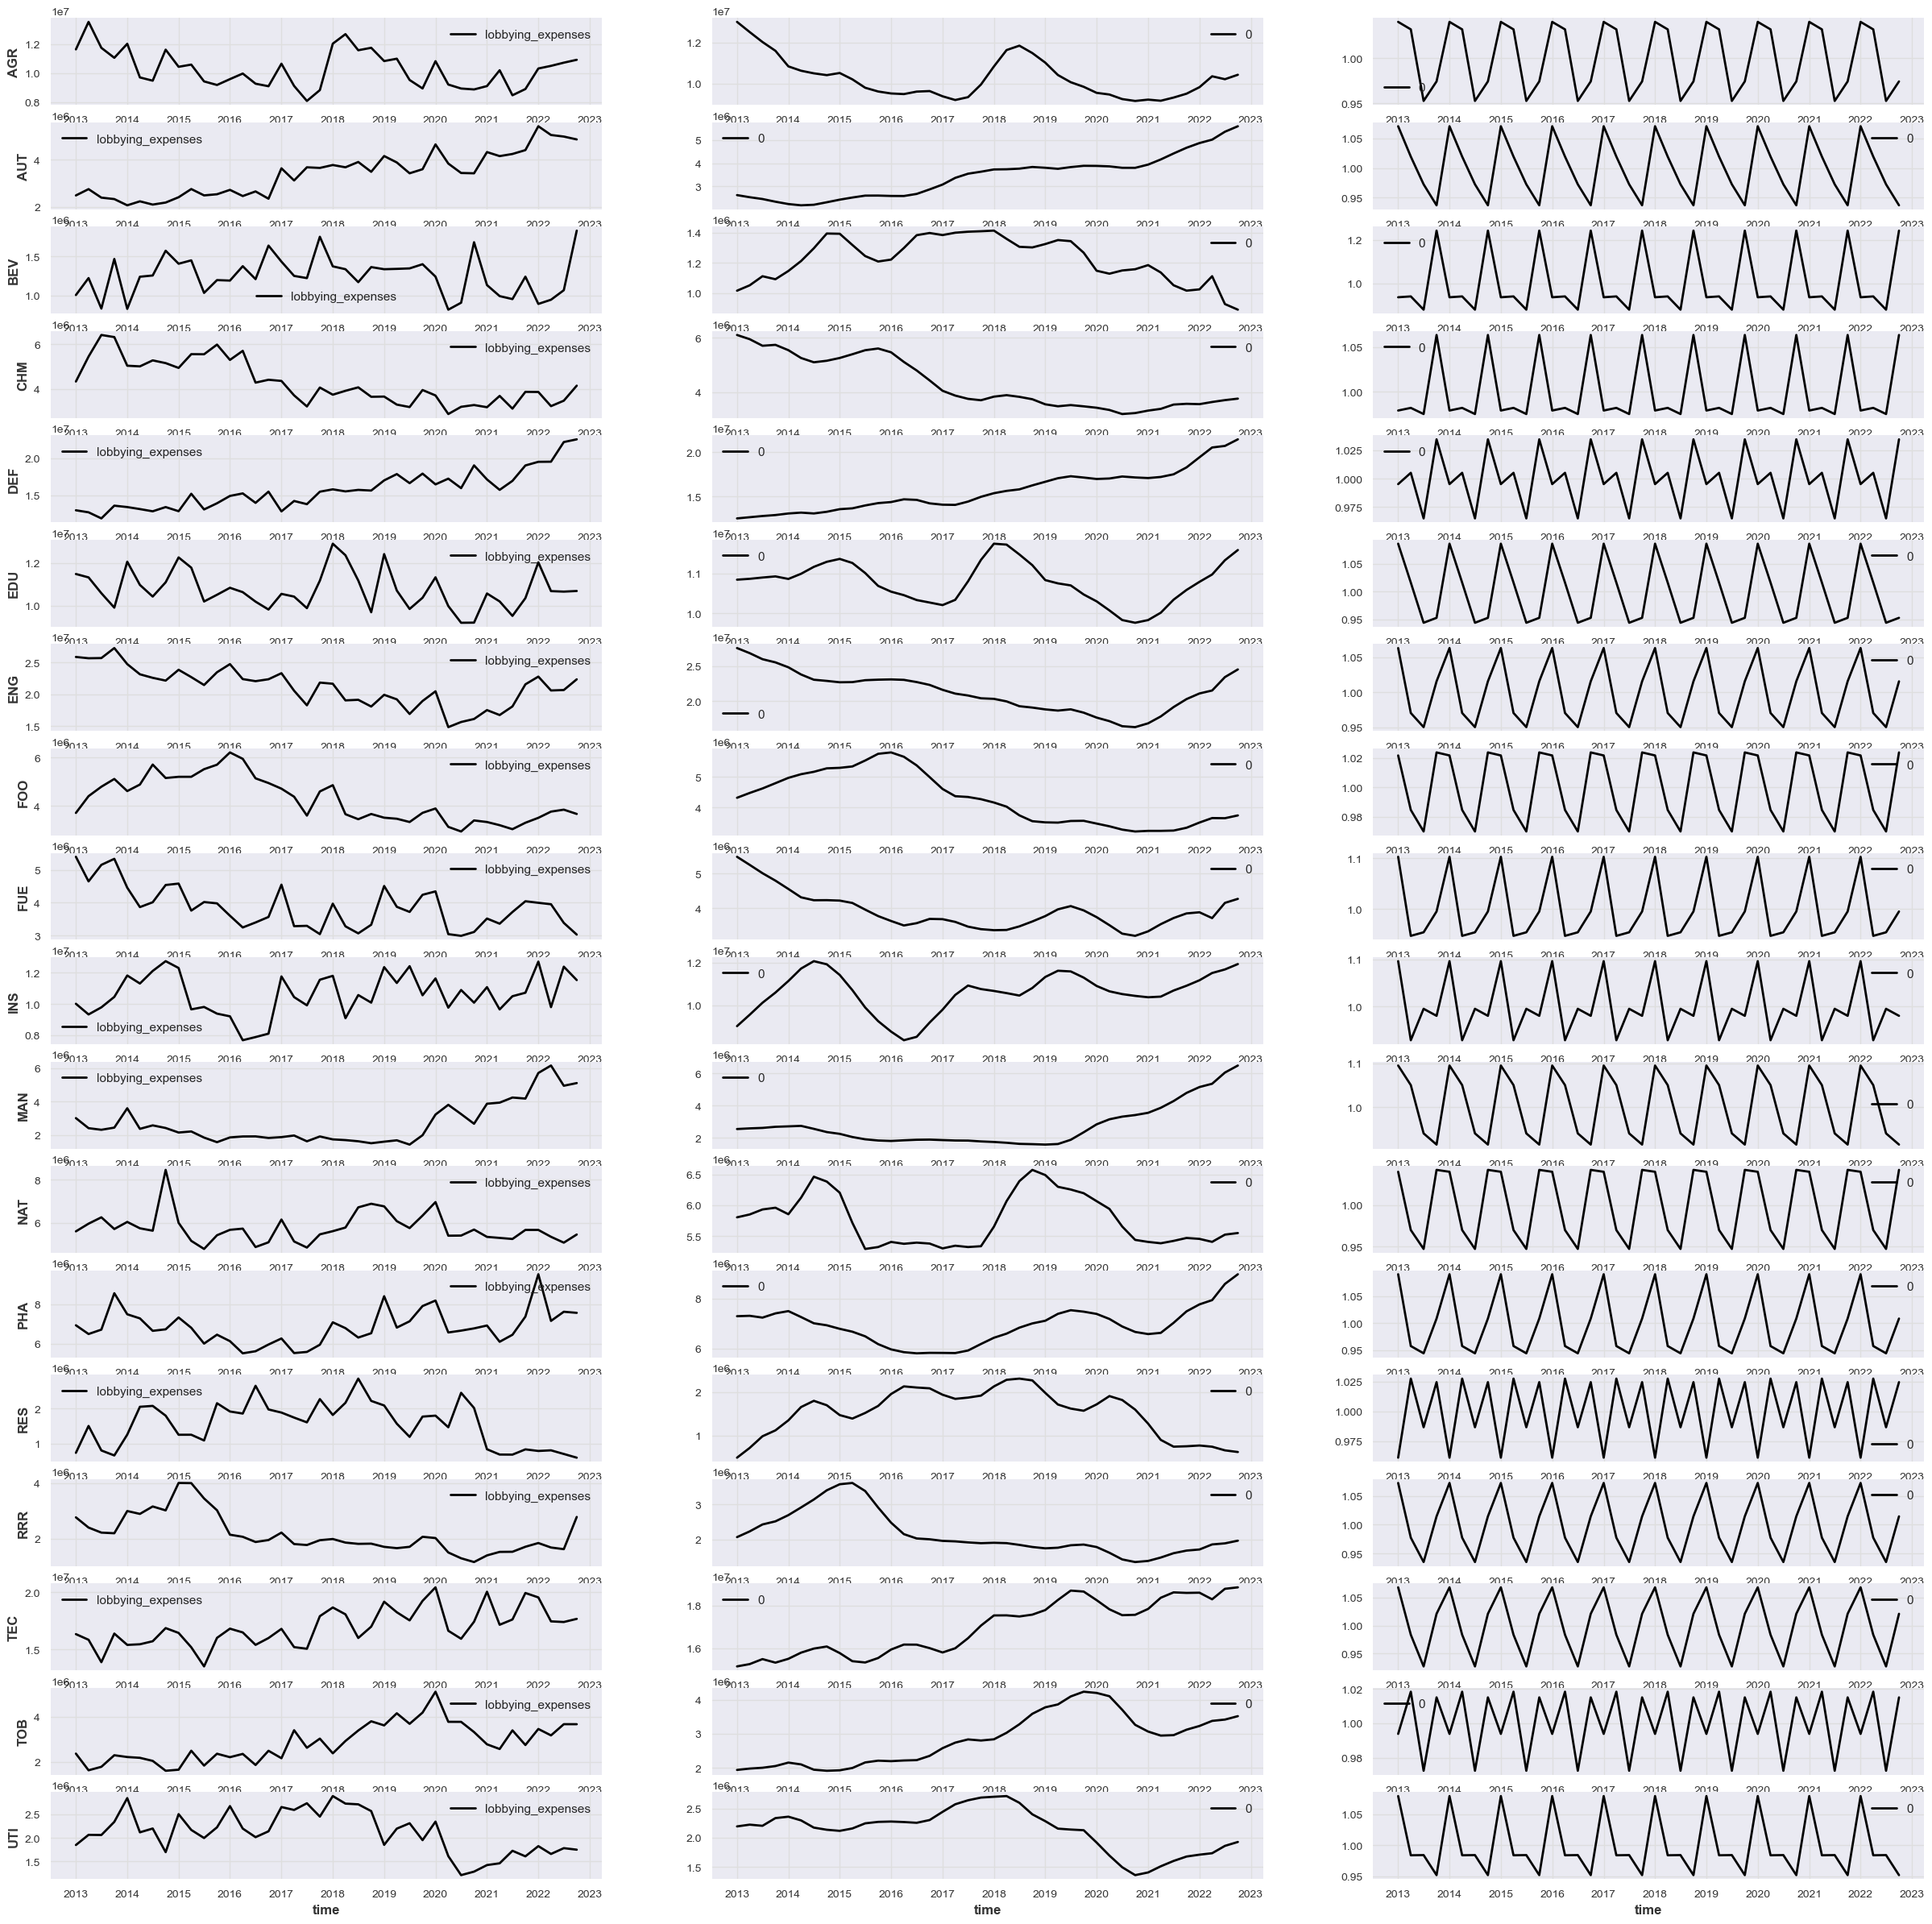

In [87]:
fig, axs=plt.subplots(len(cognates),3, figsize=(30,30))
for i,code in enumerate(cognates.keys()):
    issue=stock_and_lobbying_totals(code, cognates[code], adjust_for_num_codes=True)
    expenses=TimeSeries.from_dataframe(issue)['lobbying_expenses']
    trend, seasonality = extract_trend_and_seasonality(expenses, freq=4)
    expenses.plot(ax=axs[i,0])
    axs[i,0].set_ylabel(code)
    trend.plot(ax=axs[i,1])
    seasonality.plot(ax=axs[i,2])


##### Back to the baseline

Here's our baseline model.

**Lobbying:** expenses are modeled using a naive seasonal model, with season equal to 1 year/4 quarters; income is modeled as a random walk with drift. We model total lobbying spending as the sum of these two. More precisely:

$$ \mathrm{expenses}(t)= \mathrm{expenses}(t-4)$$
when we are forecasting; while
$$ \mathrm{income}(0)=c, \mathrm{income}(t)= \mathrm{income}(t-1)+\beta+\varepsilon_t$$
where $\varepsilon_t$ are random variables which are $\mathrm{NID}(0,\sigma_{\mathrm{income}}^2)$. $\beta$ and $\sigma_{\mathrm{income}}$ depend on sector, but are otherwise constant. The MLE estimates for our parameters are
$$ \widehat{c}=\mathrm{income}(0)$$
$$ \widehat{\beta}=\frac{1}{n}\sum_{i=1}^{n}(\mathrm{income}(i)-\mathrm{income}(i-1))$$
$$\sigma_{\mathrm{income}}^2=\frac{1}{n}\sum_{i=1}^{n}(\mathrm{income}(i)-\mathrm{income}(i-1)-\widehat{\beta})^2$$

Rem: If we use this baseline models for lobbying to forecast, then since forecasting a random walk with drift is equivalent to a naive drift model, we can quickly compute forecasts.

**Trading:** the logarithm of gross trades is given by a linear model plus white noise.
$$\log(1+\mathrm{grosstrades}(t))=\beta_0+\beta_1t+\epsilon_t$$
Here $\epsilon_t$ denotes random variables which are $\mathrm{NID}(0,\sigma_{\mathrm{trading}}^2)$. $\beta_0,\beta_1, \sigma_{\mathrm{trading}}$ depend on sector but are otherwise constant.  The MLE estimates for our parameters are the same as those given by simple linear regression.

We now write a function that produces baseline predictions, given a date to predict from and timestretch to predict for, for a given lobbying code.

### (2) Possible models, hyperparameter restrictions, and out of the box performance

We'll make a train-validation split for this first pass with out of the box models, reserving the last 4 quarters for our validation set. Later, when we tune hyperparameters, I'll make choices using cross-validation and grid-search.

Note that our data (`lobbying_total` and `stocks_gross` for various sectors) is:
- not seasonal (by this I mean as a whole - one of the premises of our baseline model is that `lobbying_expenses` component *is* roughly seasonal);
- sometimes with visible trend;
- autoregressive (to a point).

There are a lot of models we can use to try and capture this behavior.

Before we begin, here is a silly function we will call to prevent us from having to rewrite the same 3 lines of code.

In [8]:
def fit_and_pred(model, training, validation):
    model.fit(training)
    forecast = model.predict(len(validation))
    return forecast

#### Vector autoregressive integrated moving average (VARIMA)

When using a VARIMA model, we are going to fix and share some hyperparameter choices with parameters across lobbying codes. The reason for this is structural - while we believe the moving average aspect ($q$) may vary from sector to sector, we do not believe that order of growth (essentially differencing $d$) or autoregressiveness ($r$) - how much "memory" our process has - should depend on sector.  

Because of this, we will assume that the $p$ and $d$ parameters of the $(p,d,q)$ (i.e. the autoregressiveness and how much differencing is done) will be shared over all sectors. We will restrict to $d\leq 1$ based on our EDA. We will allow $q$ to vary from sector to sector, and of course will fit the model to each sector (so that the coefficients/fit will vary sector-to-sector.)
In shorthand: we are using models of the form
$$ \mathrm{VARIMA}(p=const, d=const\leq 1, q) $$

The following is a function that runs a particular model for a given {issue code : sector} in `cognates`. It takes as input
- an issue code, `issue_code`, in `cognates.keys()`;
- a model, `model` (eg. `model=VARIMA(p,d,q)`);
- a list or string of lobbying variables, `lobb_vars` (e.g. `lobby_vars=[lobbying_expenses, lobbying_income]`), and a list of stock variables, `stocks_vars`, which default to `lobb_vars=[lobbying_total]` and `stocks_vars=[stocks_gross]`;

and returns the `TimeSeries` of predictions for our model, trained over the training set, over the validation set, as well as the actual values of our time series over the whole timeframe. All data is scaled before fitting to improve model performance, and unscaled after. We included the option to take the logarithm of the stock data before fitting - in application, we found that this dramatically decreases the performance of most models.

In [41]:
def predict(issue_code, model, lobb_vars=['lobbying_total'], stocks_vars=['stocks_gross'], use_log_stocks=False):
    if isinstance(lobb_vars, str):
        lobb_vars = [lobb_vars]
    if isinstance(stocks_vars, str):
        stocks_vars = [stocks_vars]
    df=stock_and_lobbying_totals(issue_code, cognates[issue_code])[lobb_vars+stocks_vars]
    if use_log_stocks==True:
        for stocks_var in stocks_vars:
            df['log_'+stocks_var]=np.log1p(df[stocks_var])
        log_stocks_vars=['log_'+stocks_var for stocks_var in stocks_vars]
        totals_df=df[lobb_vars+log_stocks_vars]
    else:
        totals_df=df
    totals=TimeSeries.from_dataframe(totals_df)
    scaler=Scaler()
    totals_scaled =scaler.fit_transform(totals)
    train_scaled=totals_scaled[:-4]
    val_scaled=totals_scaled[-4:]
    scaled_pred = fit_and_pred(model, train_scaled, val_scaled)
    pred=scaler.inverse_transform(scaled_pred)
    if use_log_stocks==True:
        pred_df=pred.pd_dataframe()
        for stocks_var in stocks_vars:
            pred_df[stocks_var]=pred_df["log_"+stocks_var].apply(lambda x : np.expm1(x))
        df_final=pred_df[lobb_vars+stocks_vars]
        true_pred=TimeSeries.from_dataframe(df_final)
    else:
        true_pred=pred
    return true_pred, TimeSeries.from_dataframe(df)

Here's the out-of-the-box performance of VARIMA. This uses default parameters $p=1,d=0,q=0$. I also returned a dataframe with the MSSE scores for $m=1$. We can use this to get a rough sense of how well this model is performing on the validation set. In this default setup, the trend parameter in VARIMA is set to be constant.

/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AGR       AUT       BEV       CHM       DEF       EDU  \
lobbying_total  1.323284  2.892744  0.861710  0.217898  3.039256  1.041145   
stocks_gross    0.125625  7.345534  0.013933  0.041564  2.175174  0.082907   

                     ENG       FOO       FUE       INS       MAN       NAT  \
lobbying_total  0.676492  0.240510  0.085370  2.922151  8.124825  0.057847   
stocks_gross    0.051196  0.271209  3.905694  0.275597  0.866391  1.256002   

                     PHA       RES       RRR       TEC       TOB       UTI  
lobbying_total  1.337273  0.013117  7.866425  1.660427  1.335166  0.249368  
stocks_gross    1.179350  0.927735  0.041334  0.342879  0.918676  0.995827

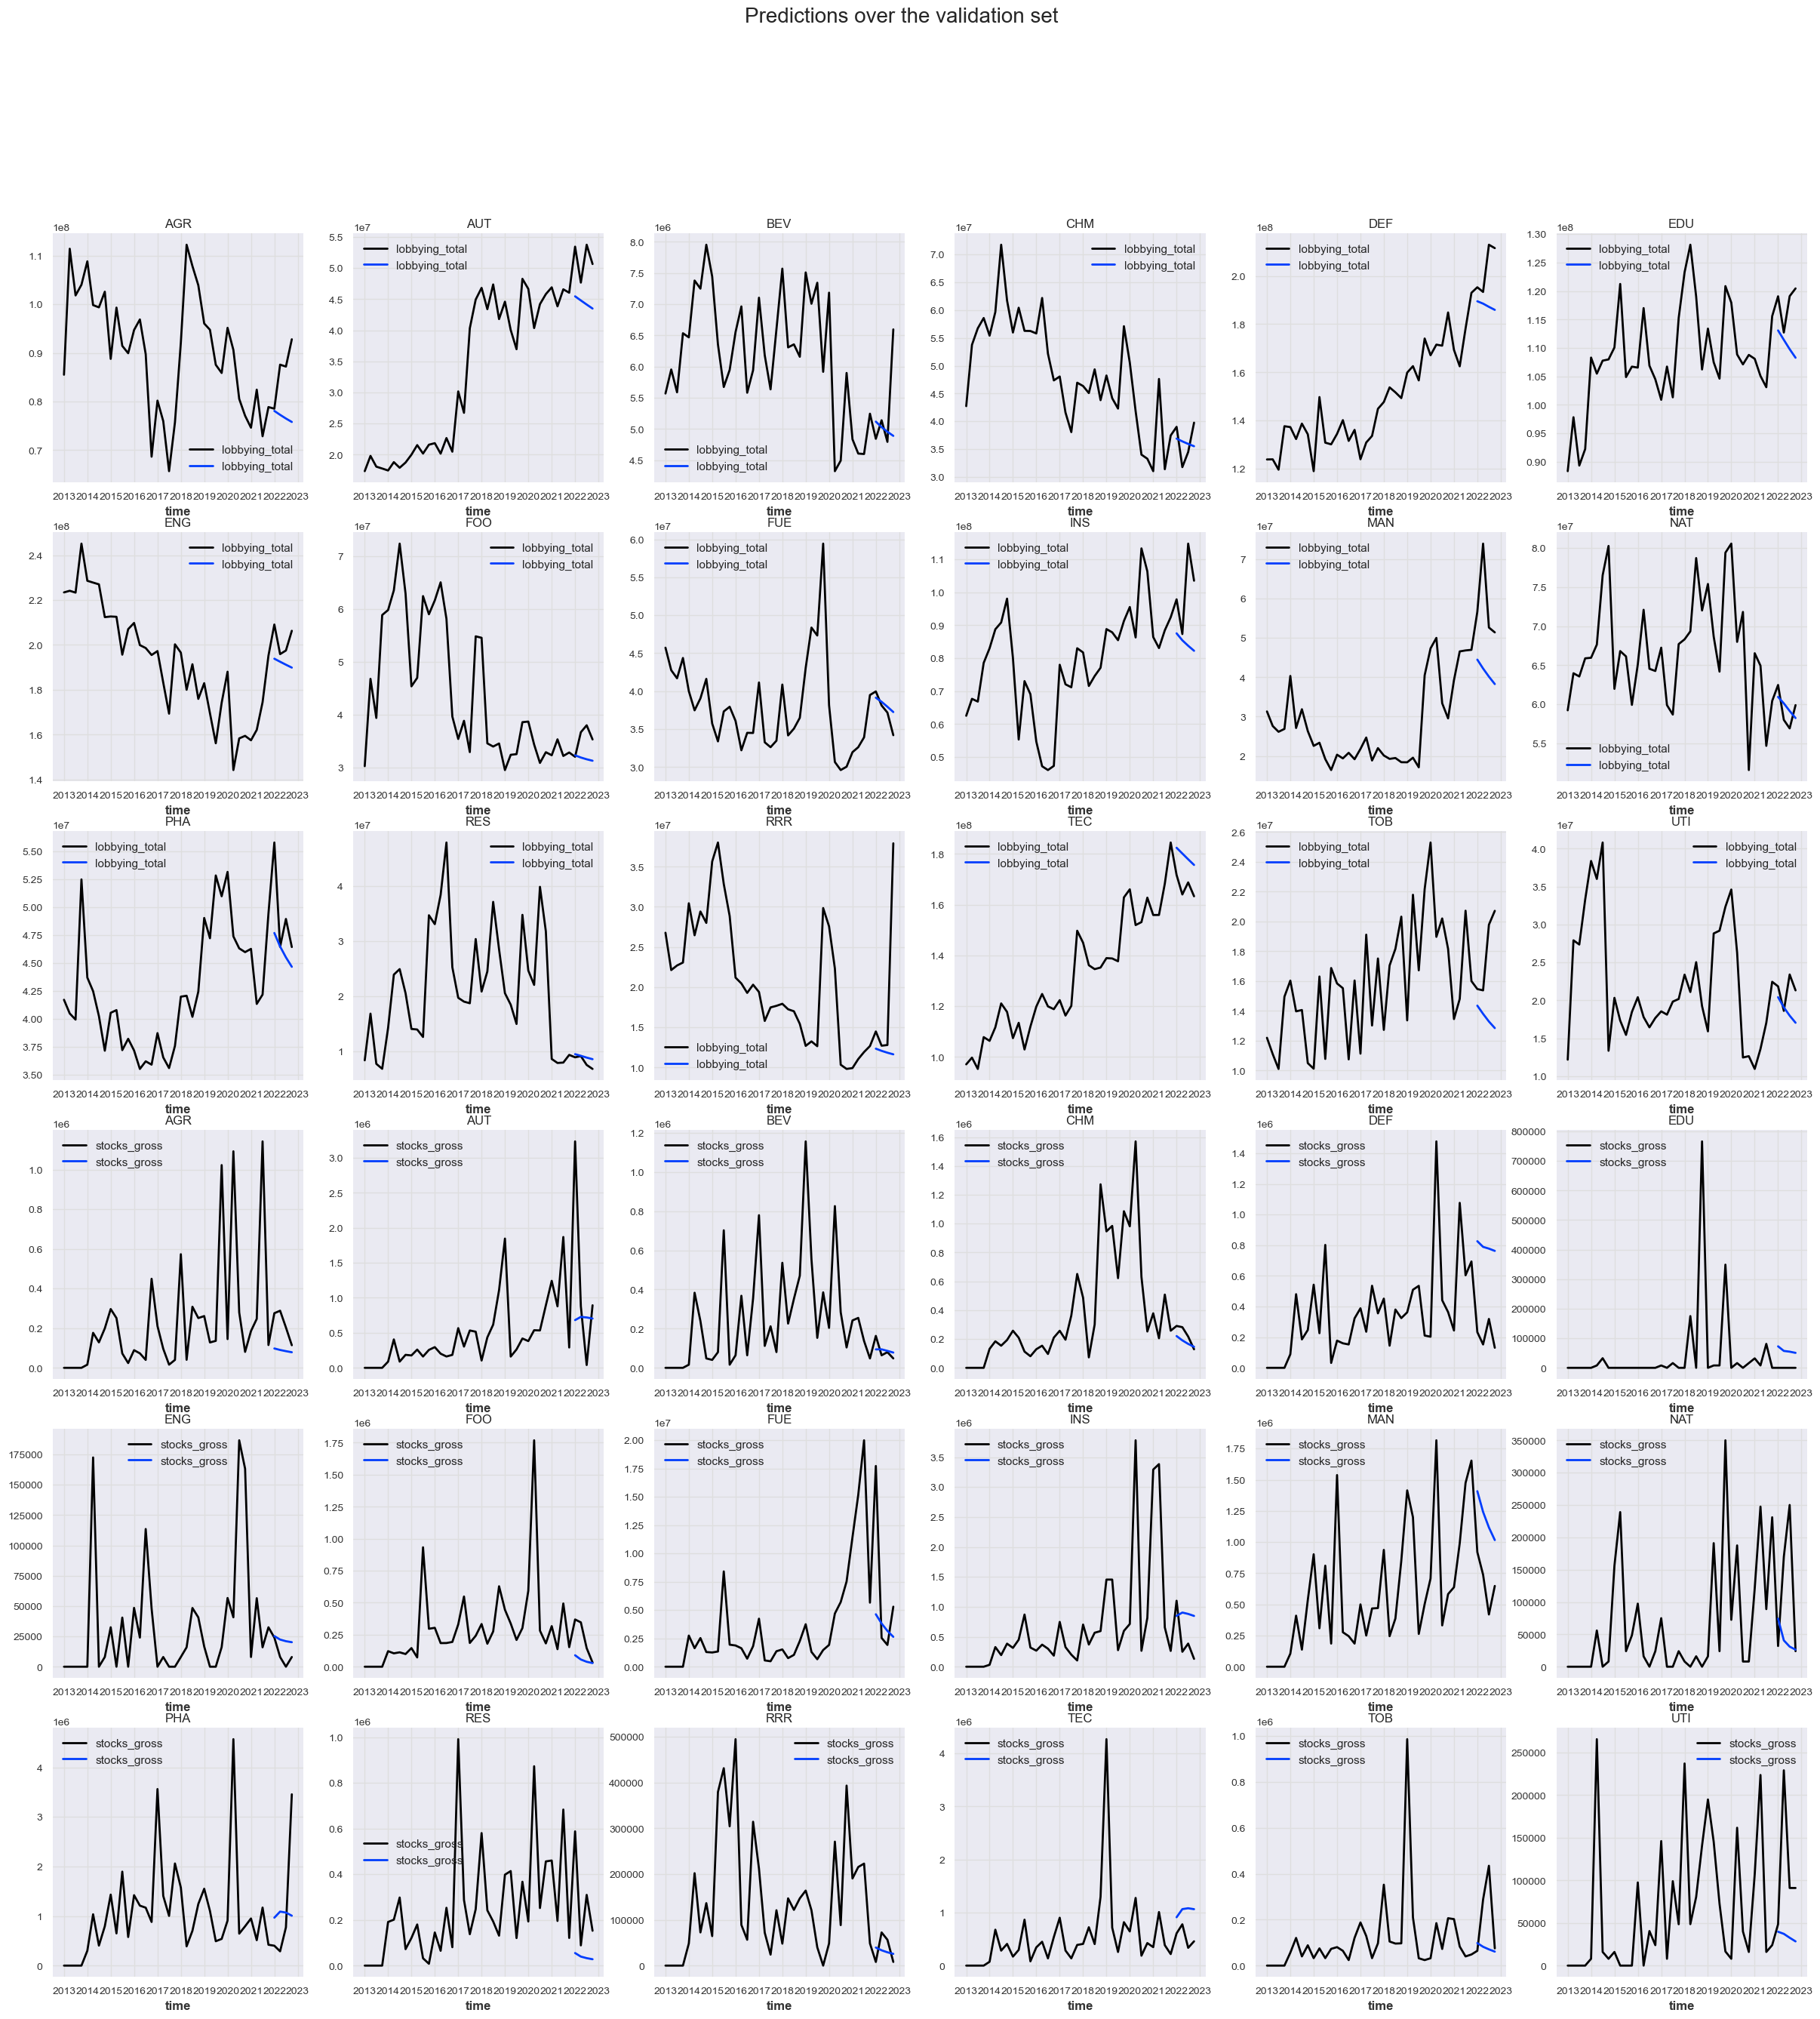

In [42]:
VARIMA_default = VARIMA()
lobb_vars=['lobbying_total']
stocks_vars=['stocks_gross']
performance=pd.DataFrame()
fig, axs = plt.subplots(6, 6, figsize=(30, 30))
axs=axs.flatten()
fig.suptitle('Predictions over the validation set', size=20)
for i, code in enumerate(cognates.keys()):
    pred, actual = predict(issue_code=code, model=VARIMA_default)
    actual['lobbying_total'].plot(ax= axs[i])
    pred['lobbying_total'].plot(ax= axs[i])
    axs[i].set_title(code)
    actual['stocks_gross'].plot(ax= axs[i+18])
    pred['stocks_gross'].plot(ax= axs[i+18])
    axs[i+18].set_title(code)
    code_performance=[msse(actual[variable][-4:], pred[variable], actual[variable][:-4], m=1) for variable in lobb_vars+stocks_vars] #msse with 1-seasonality
    performance[code]=code_performance
performance.index=lobb_vars+stocks_vars
display(performance)

In [43]:
performance.sum(axis=1)

lobbying_total    33.945009
stocks_gross      20.816627
dtype: float64

Here's default performance with a trend.

/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/

AGR       AUT       BEV       CHM       DEF       EDU  \
lobbying_total  0.568246  0.473588  0.570843  0.632825  4.228800  0.218811   
stocks_gross    0.470031  6.589277  0.838371  1.767863  1.804557  0.181370   

                     ENG       FOO       FUE       INS       MAN       NAT  \
lobbying_total  0.251807  0.049901  0.593539  0.686298  7.841748  1.551767   
stocks_gross    0.722031  0.820549  3.934824  1.044337  1.085893  0.744023   

                     PHA       RES       RRR       TEC       TOB       UTI  
lobbying_total  1.021280  1.804793  5.483747  0.869570  0.622038  0.181890  
stocks_gross    1.203459  0.716669  0.733695  0.254441  0.444784  0.443654

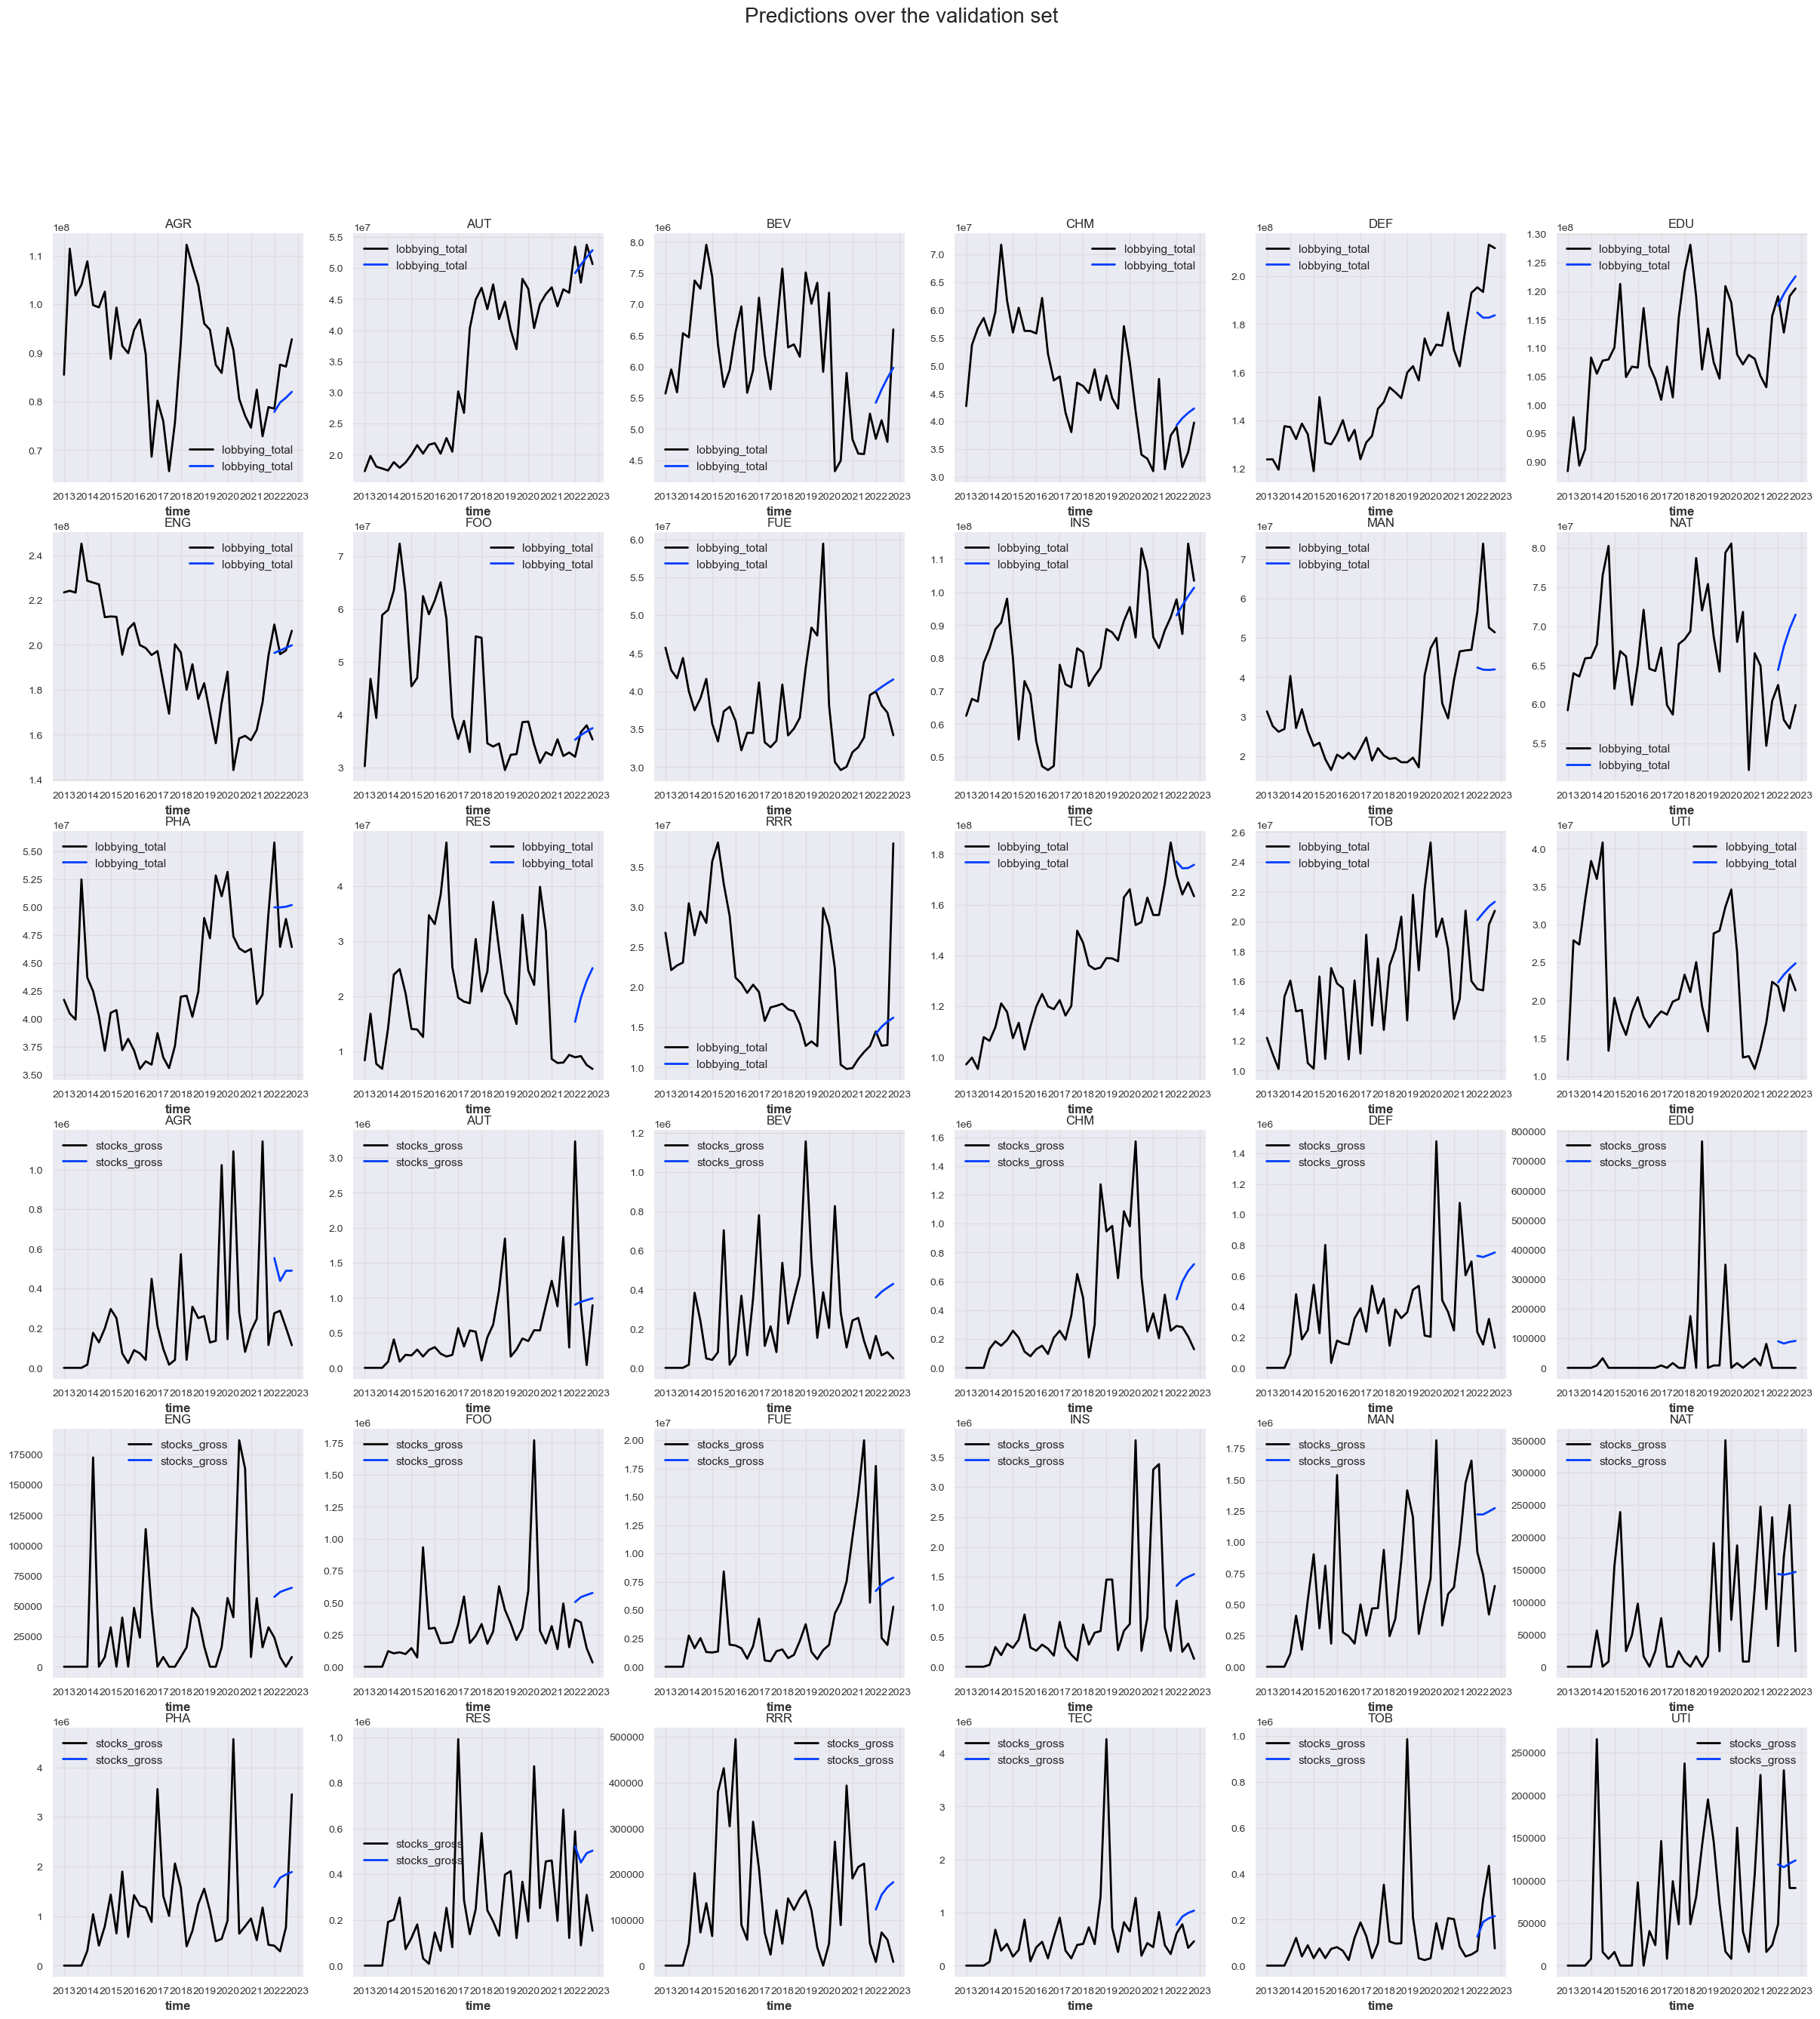

In [44]:
VARIMA_default_t = VARIMA(trend='t')
lobb_vars=['lobbying_total']
stocks_vars=['stocks_gross']
VARIMA_default_t_performance=pd.DataFrame()
fig, axs = plt.subplots(6, 6, figsize=(30, 30))
axs=axs.flatten()
fig.suptitle('Predictions over the validation set', size=20)
for i, code in enumerate(cognates.keys()):
    pred, actual = predict(issue_code=code, model=VARIMA_default_t)
    actual['lobbying_total'].plot(ax= axs[i])
    pred['lobbying_total'].plot(ax= axs[i])
    axs[i].set_title(code)
    actual['stocks_gross'].plot(ax= axs[i+18])
    pred['stocks_gross'].plot(ax= axs[i+18])
    axs[i+18].set_title(code)
    code_performance=[msse(actual[variable][-4:], pred[variable], actual[variable][:-4], m=1) for variable in lobb_vars+stocks_vars] #msse with 1-seasonality
    VARIMA_default_t_performance[code]=code_performance
VARIMA_default_t_performance.index=lobb_vars+stocks_vars
display(VARIMA_default_t_performance)

    

In [45]:
VARIMA_default_t_performance.sum(axis=1)

lobbying_total    27.651490
stocks_gross      23.799827
dtype: float64

The predictions are pretty awful. Putting in trend seems to have made things better at modeling lobbying, but worse at modeling stocks, at least when $d=0$.

Let's try again with $p=1, d=1, q=0$, with no trend.

AGR       AUT       BEV       CHM       DEF       EDU  \
lobbying_total  1.701078  2.478763  0.681828  0.227983  2.651885  0.517339   
stocks_gross    0.931610  5.742101  0.010749  0.169238  1.336918  0.002486   

                     ENG       FOO       FUE       INS       MAN       NAT  \
lobbying_total  0.910446  0.097215  0.229146  1.379792  4.939395  0.069058   
stocks_gross    0.053447  0.122157  3.604308  0.132673  2.653459  0.800432   

                     PHA       RES       RRR       TEC       TOB       UTI  
lobbying_total  1.295847  0.038676  6.805325  3.418126  0.345366  0.063683  
stocks_gross    1.340246  0.162895  0.306127  0.112288  1.214726  1.191292

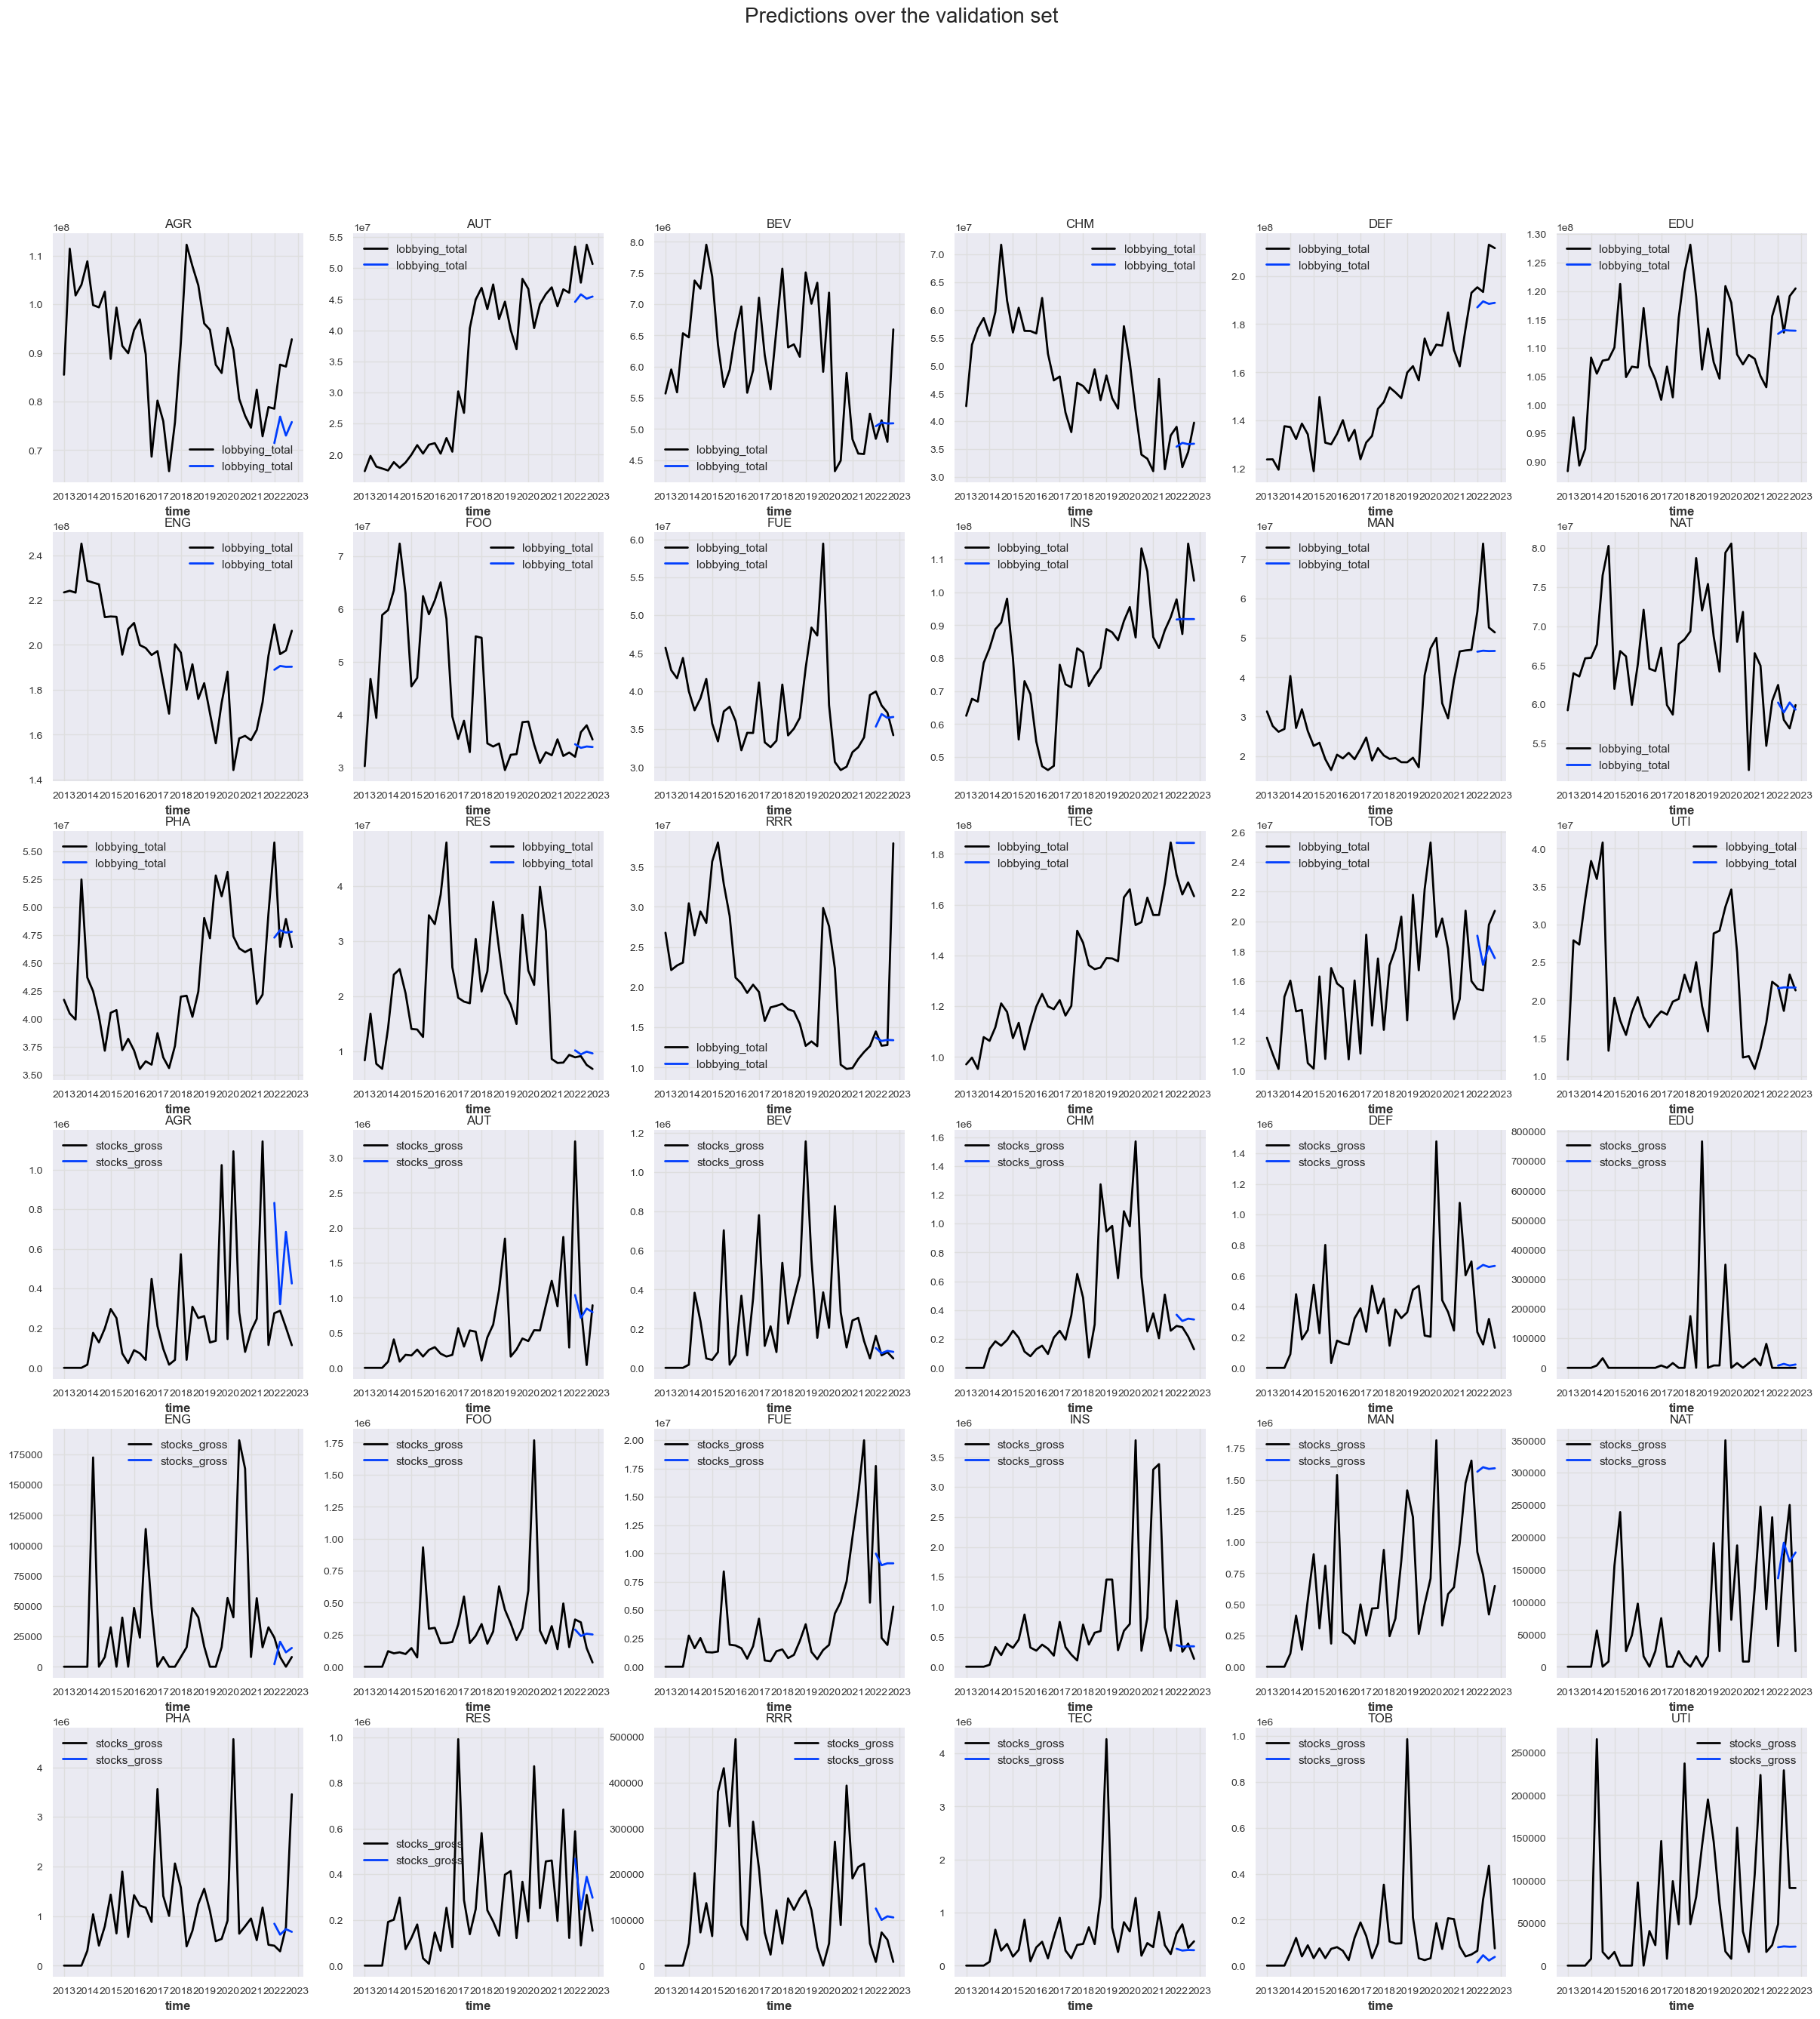

In [94]:
VARIMA_d_1 = VARIMA(d=1)
lobb_vars=['lobbying_total']
stocks_vars=['stocks_gross']
VARIMA_d_1_performance=pd.DataFrame()
fig, axs = plt.subplots(6, 6, figsize=(30, 30))
axs=axs.flatten()
fig.suptitle('Predictions over the validation set', size=20)
for i, code in enumerate(cognates.keys()):
    pred, actual = predict(issue_code=code, model=VARIMA_d_1)
    actual['lobbying_total'].plot(ax= axs[i])
    pred['lobbying_total'].plot(ax= axs[i])
    axs[i].set_title(code)
    actual['stocks_gross'].plot(ax= axs[i+18])
    pred['stocks_gross'].plot(ax= axs[i+18])
    axs[i+18].set_title(code)
    code_performance=[msse(actual[variable][-4:], pred[variable], actual[variable][:-4], m=1) for variable in lobb_vars+stocks_vars] #msse with 1-seasonality
    VARIMA_d_1_performance[code]=code_performance
VARIMA_d_1_performance.index=lobb_vars+stocks_vars
display(VARIMA_d_1_performance)


In [95]:
VARIMA_d_1_performance.sum(axis=1)

lobbying_total    27.850951
stocks_gross      19.887150
dtype: float64

This is better at stocks, and slightly worse at lobbying. And with trend?

/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/

AGR       AUT      BEV       CHM       DEF       EDU  \
lobbying_total  3.029723  0.911692  1.10257  0.546714  0.529557  0.343916   
stocks_gross    1.372690  5.568369  0.02254  0.151633  1.822631  0.000451   

                     ENG       FOO       FUE       INS       MAN       NAT  \
lobbying_total  1.014201  0.291288  0.268706  0.937211  3.467856  0.098312   
stocks_gross    0.046200  0.110512  5.098005  0.136948  4.278487  1.083329   

                     PHA       RES       RRR       TEC       TOB       UTI  
lobbying_total  1.342065  0.017928  8.456161  9.523849  0.318692  0.063275  
stocks_gross    1.459529  0.204741  0.266002  0.154078  1.391537  1.373786

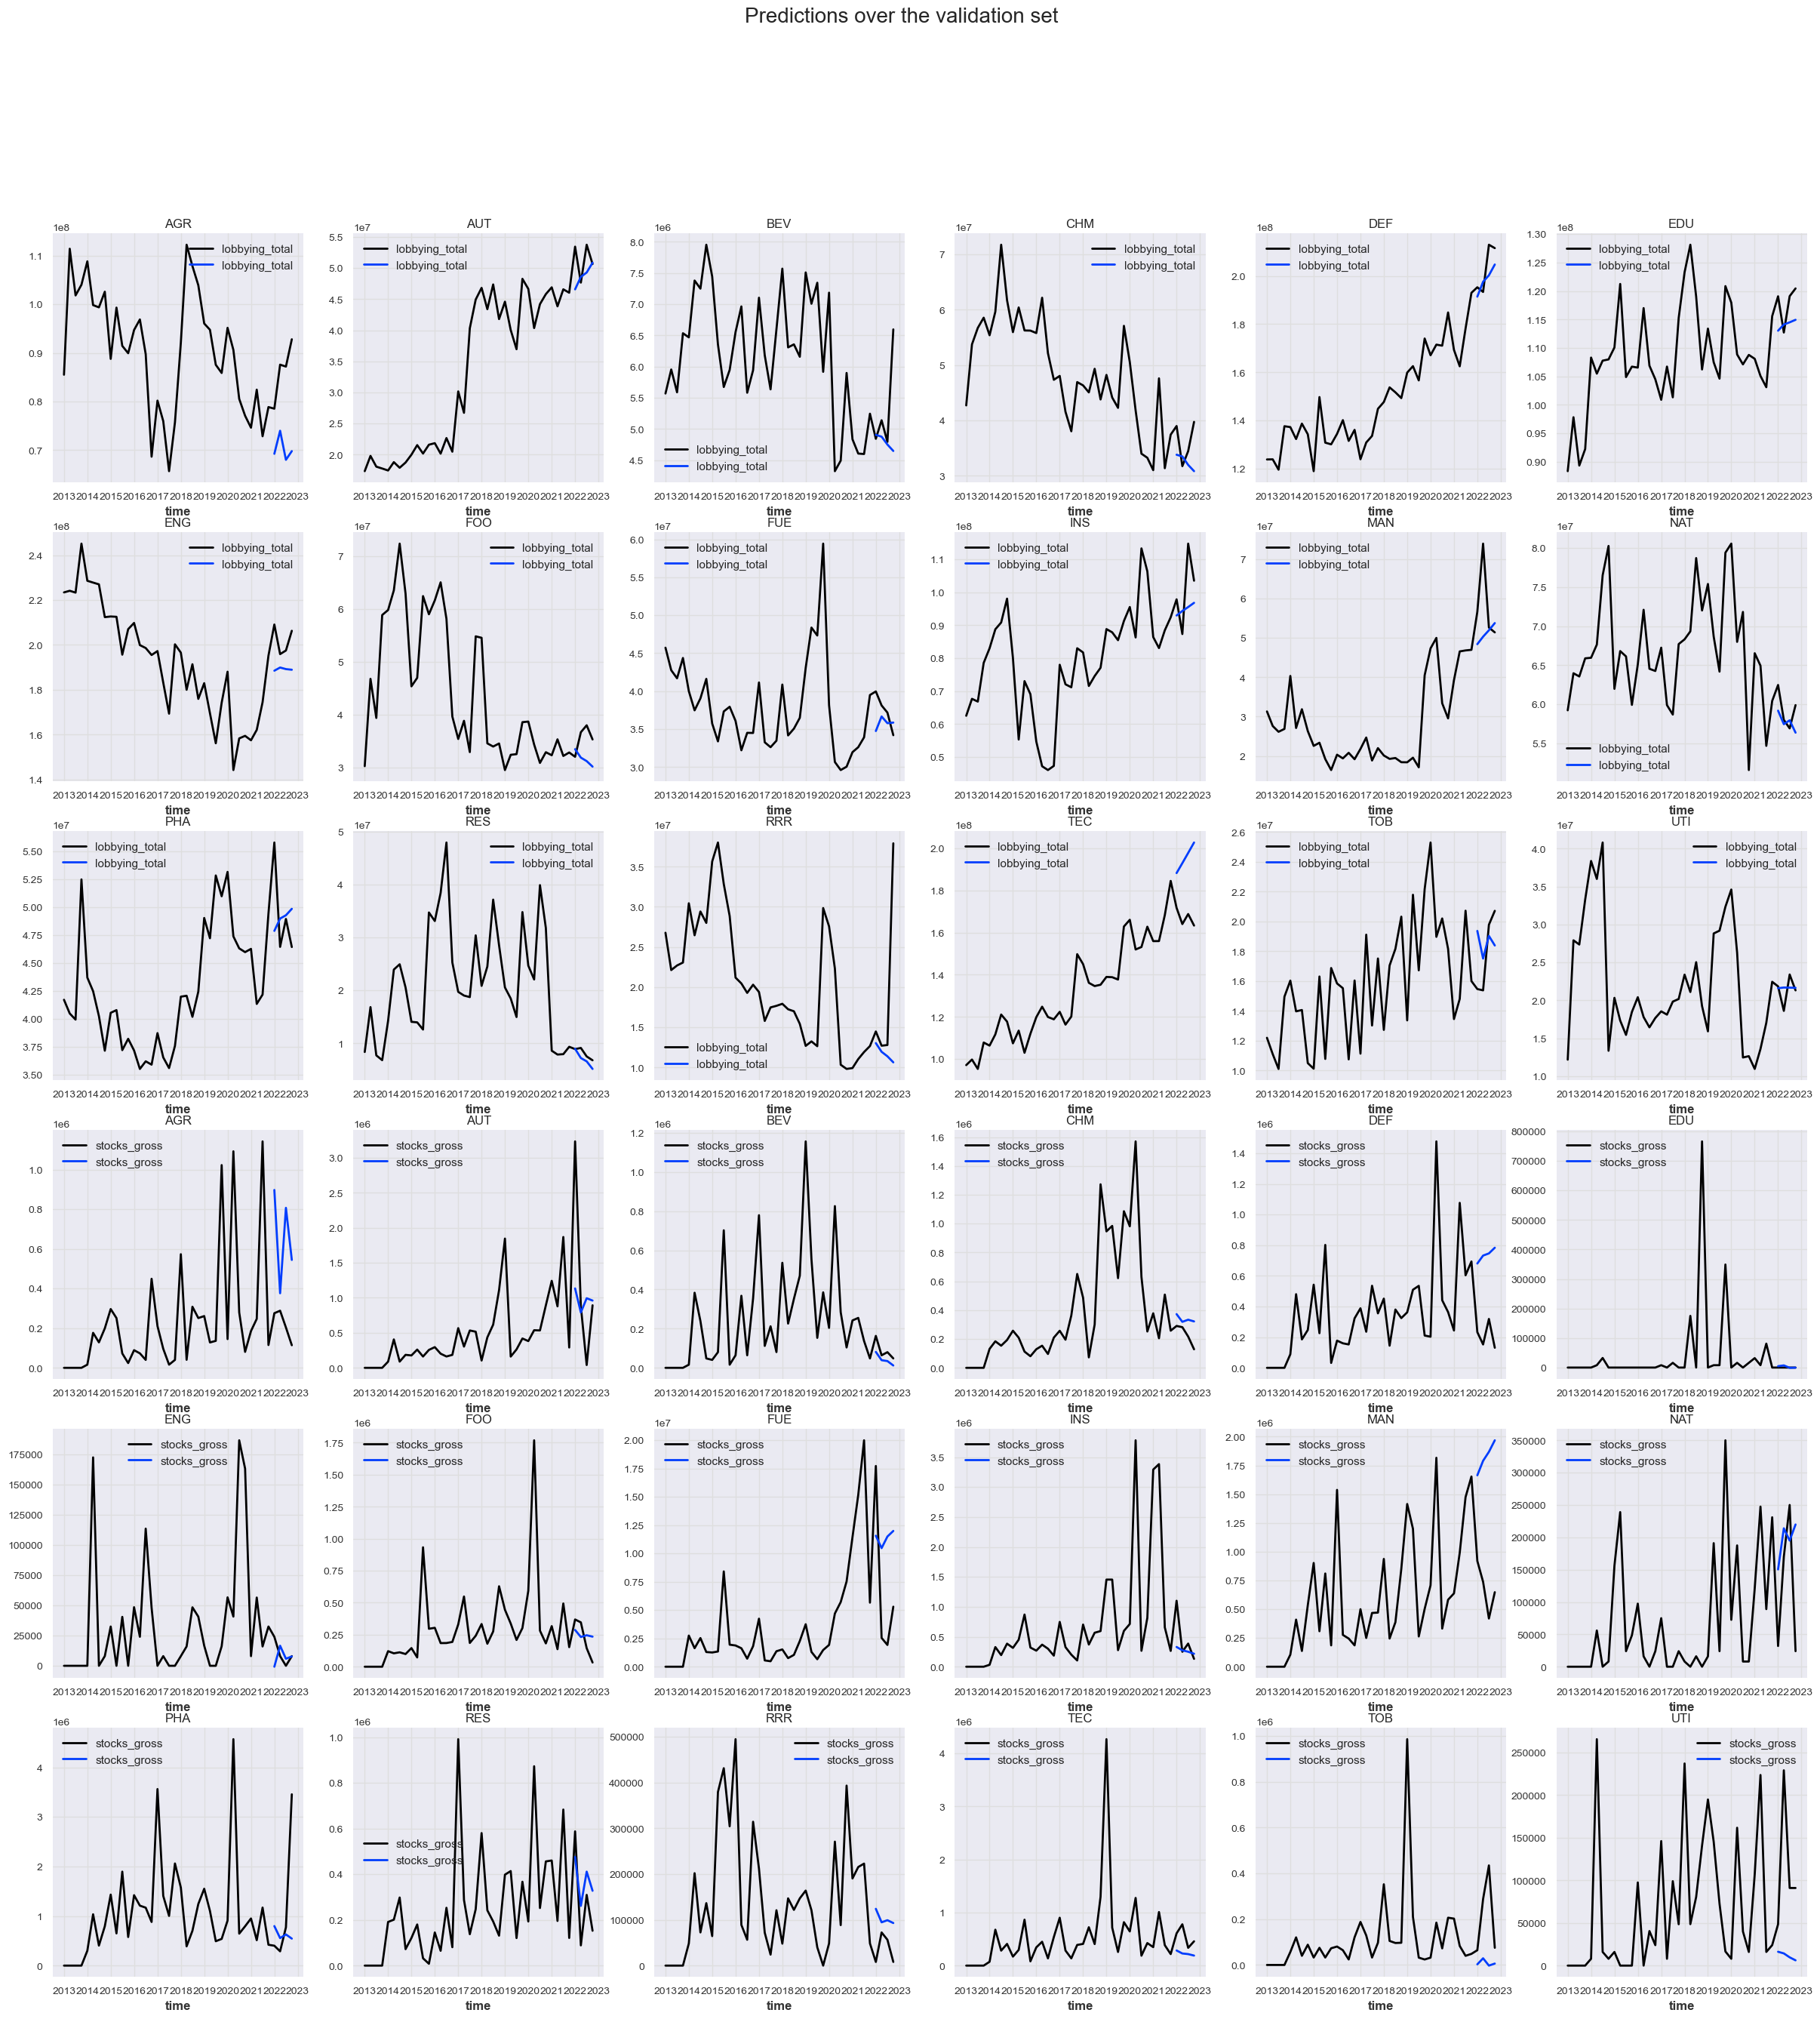

In [96]:
VARIMA_d_1_t = VARIMA(d=1, trend='t')
lobb_vars=['lobbying_total']
stocks_vars=['stocks_gross']
d_1_t_performance=pd.DataFrame()
fig, axs = plt.subplots(6, 6, figsize=(30, 30))
axs=axs.flatten()
fig.suptitle('Predictions over the validation set', size=20)
for i, code in enumerate(cognates.keys()):
    pred, actual = predict(issue_code=code, model=VARIMA_d_1_t)
    actual['lobbying_total'].plot(ax= axs[i])
    pred['lobbying_total'].plot(ax= axs[i])
    axs[i].set_title(code)
    actual['stocks_gross'].plot(ax= axs[i+18])
    pred['stocks_gross'].plot(ax= axs[i+18])
    axs[i+18].set_title(code)
    code_performance=[msse(actual[variable][-4:], pred[variable], actual[variable][:-4], m=1) for variable in lobb_vars+stocks_vars] #msse with 1-seasonality
    d_1_t_performance[code]=code_performance
d_1_t_performance.index=lobb_vars+stocks_vars
display(d_1_t_performance)

In [97]:
d_1_t_performance.sum(axis=1)

lobbying_total    32.263716
stocks_gross      24.541467
dtype: float64

Good god, it got worse!

#### XGBoost Model

I'll try XGBoost with default parameters and lags=4.

AGR       AUT       BEV       CHM       DEF       EDU  \
lobbying_total  1.12873  3.805806  0.611297  1.549412  7.577084  1.527309   
stocks_gross    0.36781  9.419604  0.058608  2.648831  4.865338  0.005377   

                     ENG       FOO       FUE       INS       MAN       NAT  \
lobbying_total  6.274599  1.691639  0.109064  1.387848  9.287081  0.333530   
stocks_gross    0.134124  0.254938  5.694835  2.835233  0.625682  0.743895   

                     PHA       RES       RRR       TEC       TOB       UTI  
lobbying_total  1.482495  2.056468  6.705196  0.694562  1.194908  0.178149  
stocks_gross    1.246612  0.123120  0.302637  0.116791  0.836260  0.965926

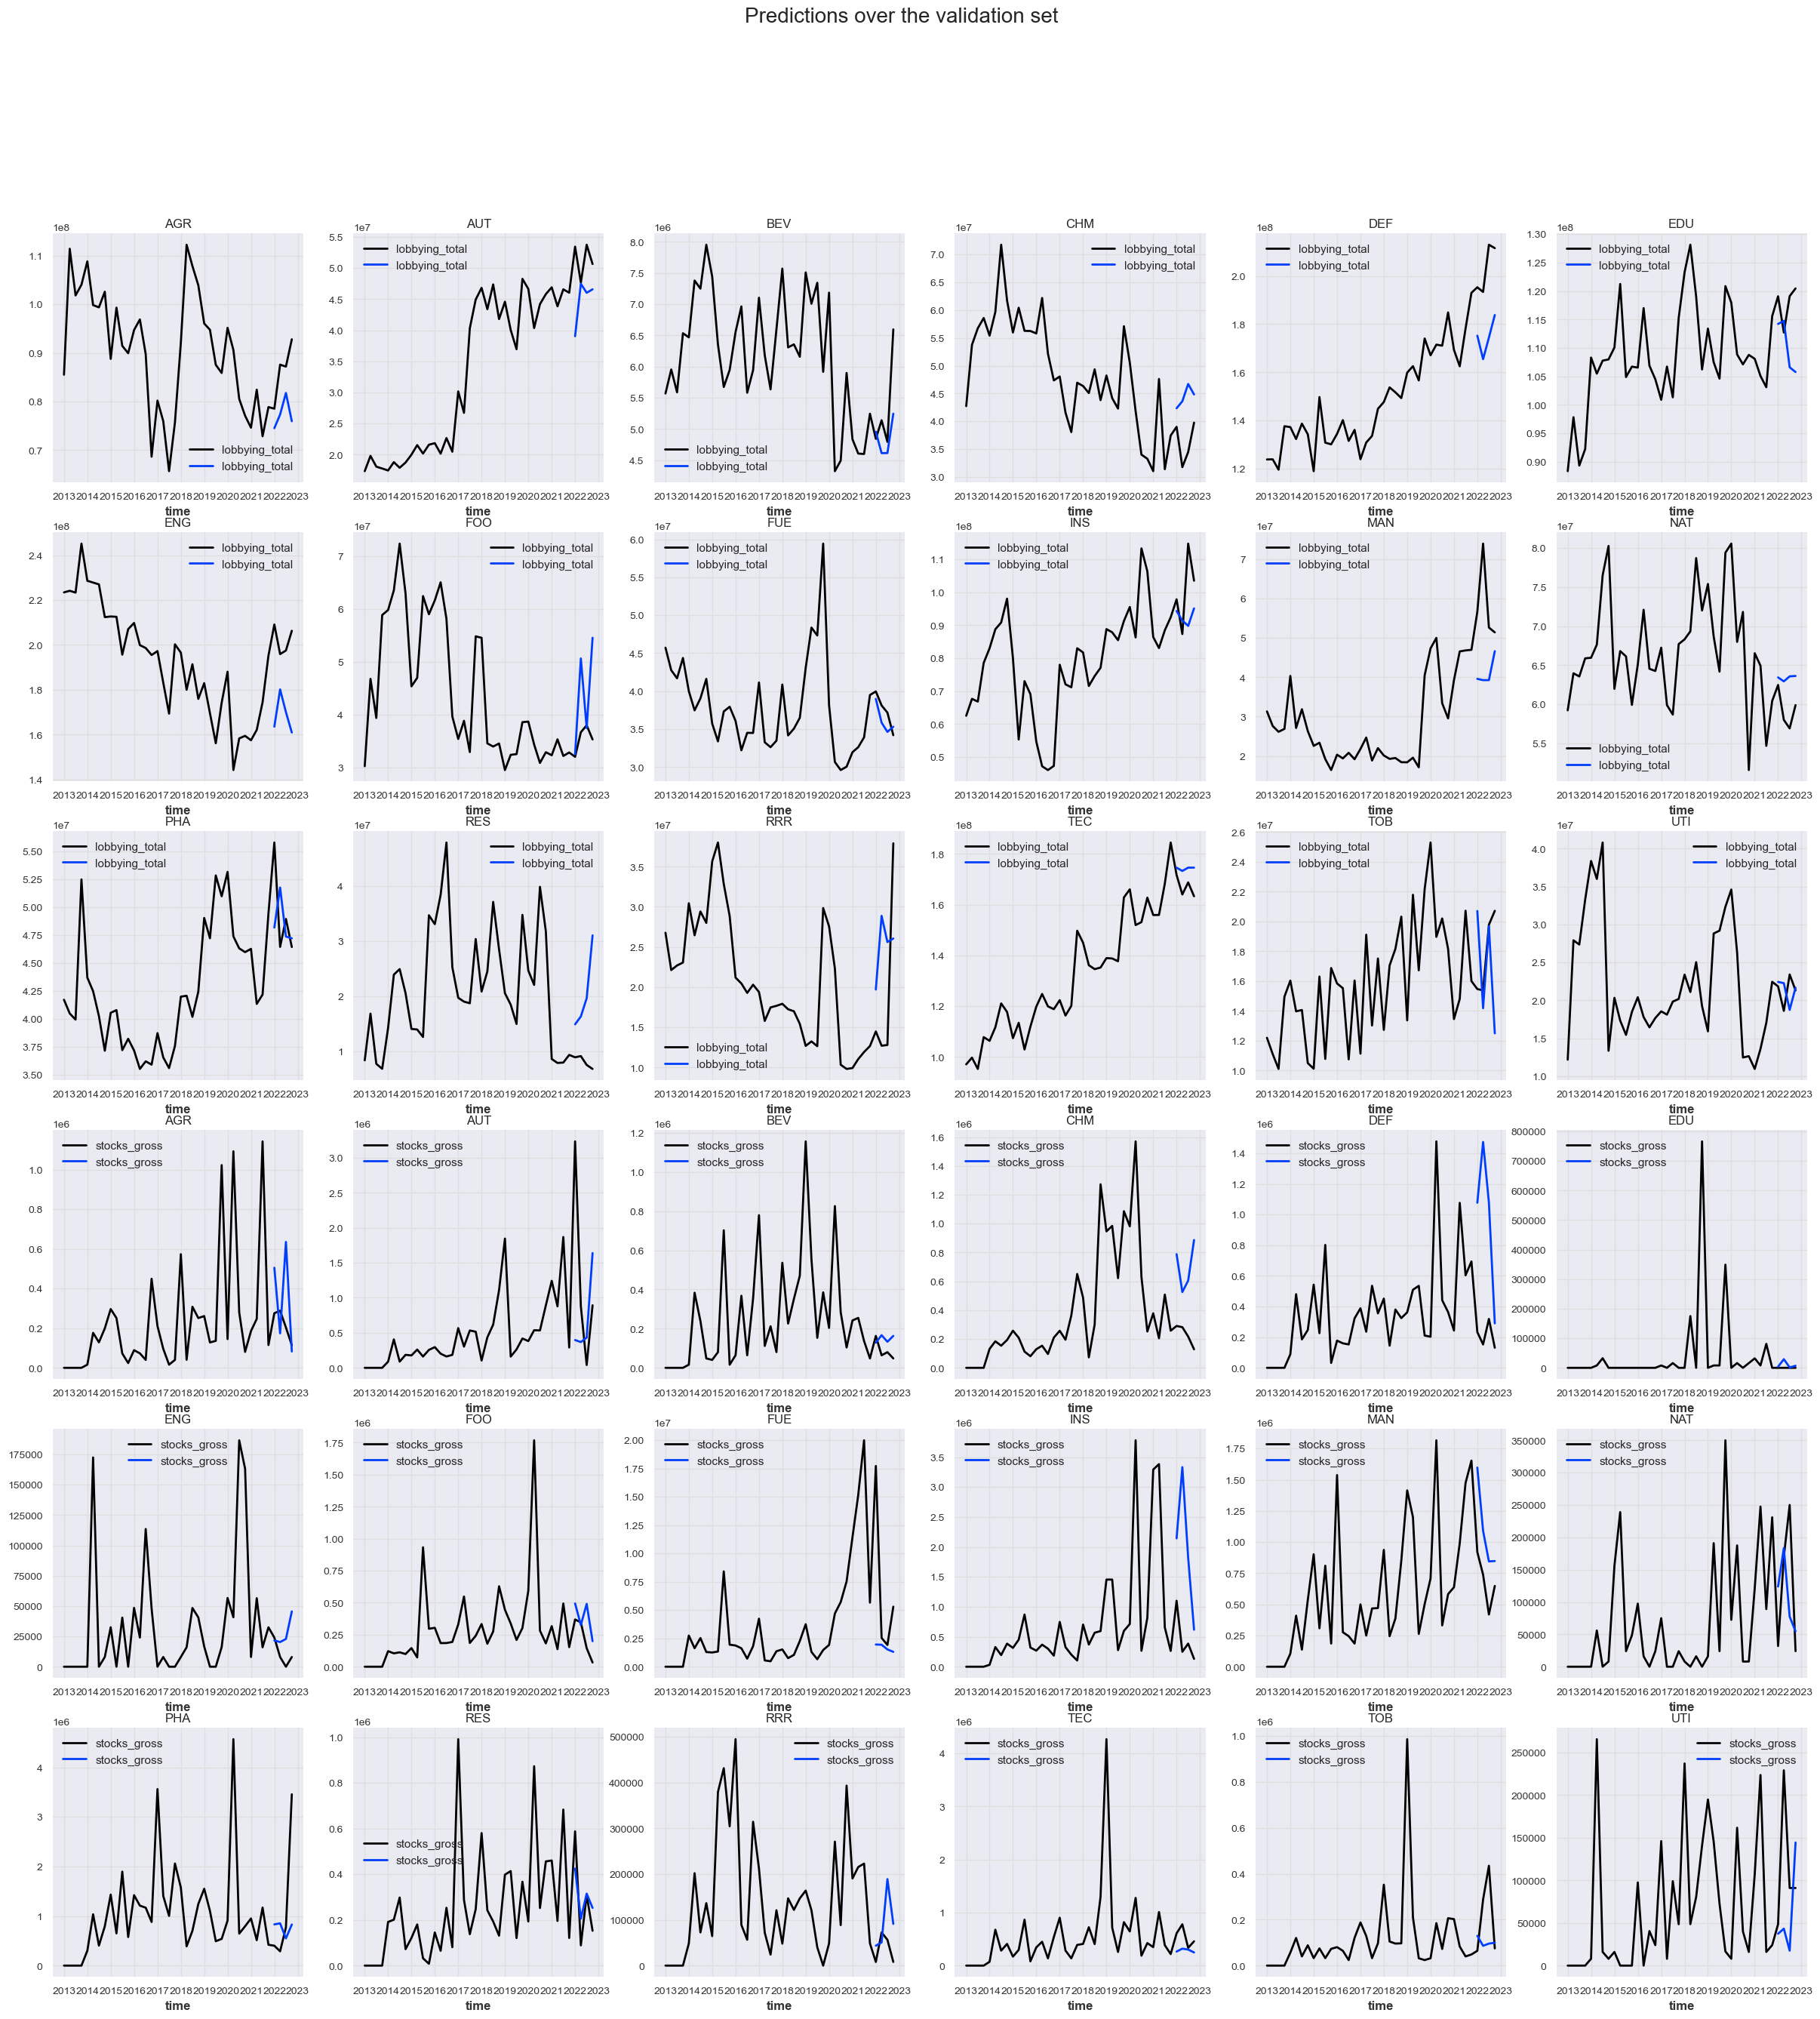

In [98]:
xgb_default = XGBModel(lags=4, random_state=691)
lobb_vars=['lobbying_total']
stocks_vars=['stocks_gross']
xgb_default_performance=pd.DataFrame()
fig, axs = plt.subplots(6, 6, figsize=(30, 30))
axs=axs.flatten()
fig.suptitle('Predictions over the validation set', size=20)
for i, code in enumerate(cognates.keys()):
    pred, actual = predict(issue_code=code, model=xgb_default)
    actual['lobbying_total'].plot(ax= axs[i])
    pred['lobbying_total'].plot(ax= axs[i])
    axs[i].set_title(code)
    actual['stocks_gross'].plot(ax= axs[i+18])
    pred['stocks_gross'].plot(ax= axs[i+18])
    axs[i+18].set_title(code)
    code_performance=[msse(actual[variable][-4:], pred[variable], actual[variable][:-4], m=1) for variable in lobb_vars+stocks_vars] #msse with 1-seasonality
    xgb_default_performance[code]=code_performance
xgb_default_performance.index=lobb_vars+stocks_vars
display(xgb_default_performance)

In [99]:
xgb_default_performance.sum(axis=1)

lobbying_total    47.595178
stocks_gross      31.245622
dtype: float64

It's OK... worse than out of the box VARIMA, but with some tuning it can hopefully do better.

#### Neural Basis Expansion Analysis Time Series Forecasting (N-BEATS)

This is a neural network model with a rather sophisticated architecture, designed for time series forecasting. We run it more-or-less out of the box here.

In [71]:
NBEATS_generic = NBEATSModel(
    input_chunk_length=15,
    output_chunk_length=15,
    generic_architecture=True,
    num_stacks=4,
    num_blocks=1,
    num_layers=4,
    layer_widths=25,
    n_epochs=100,
    nr_epochs_val_period=1,
    batch_size=32,
    random_state=691,
    model_name='nbeats_generic',
    save_checkpoints=True,
    force_reset=True,
    **generate_torch_kwargs(),
)

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

AGR        AUT       BEV       CHM        DEF       EDU  \
lobbying_total  0.212023   1.894489  1.906139  1.656922  23.922415  2.236277   
stocks_gross    0.169137  19.992004  1.589747  3.143642   1.352115  5.397071   

                     ENG       FOO       FUE       INS        MAN       NAT  \
lobbying_total  0.852414  0.992656  0.462460  4.864045  43.603881  1.435210   
stocks_gross    0.320068  0.588782  6.109758  0.219855   0.763684  1.262241   

                     PHA       RES       RRR       TEC       TOB       UTI  
lobbying_total  9.590220  4.951521  5.473489  9.771734  0.538882  0.249400  
stocks_gross    1.171322  0.286681  0.556645  1.614967  1.391400  0.865388

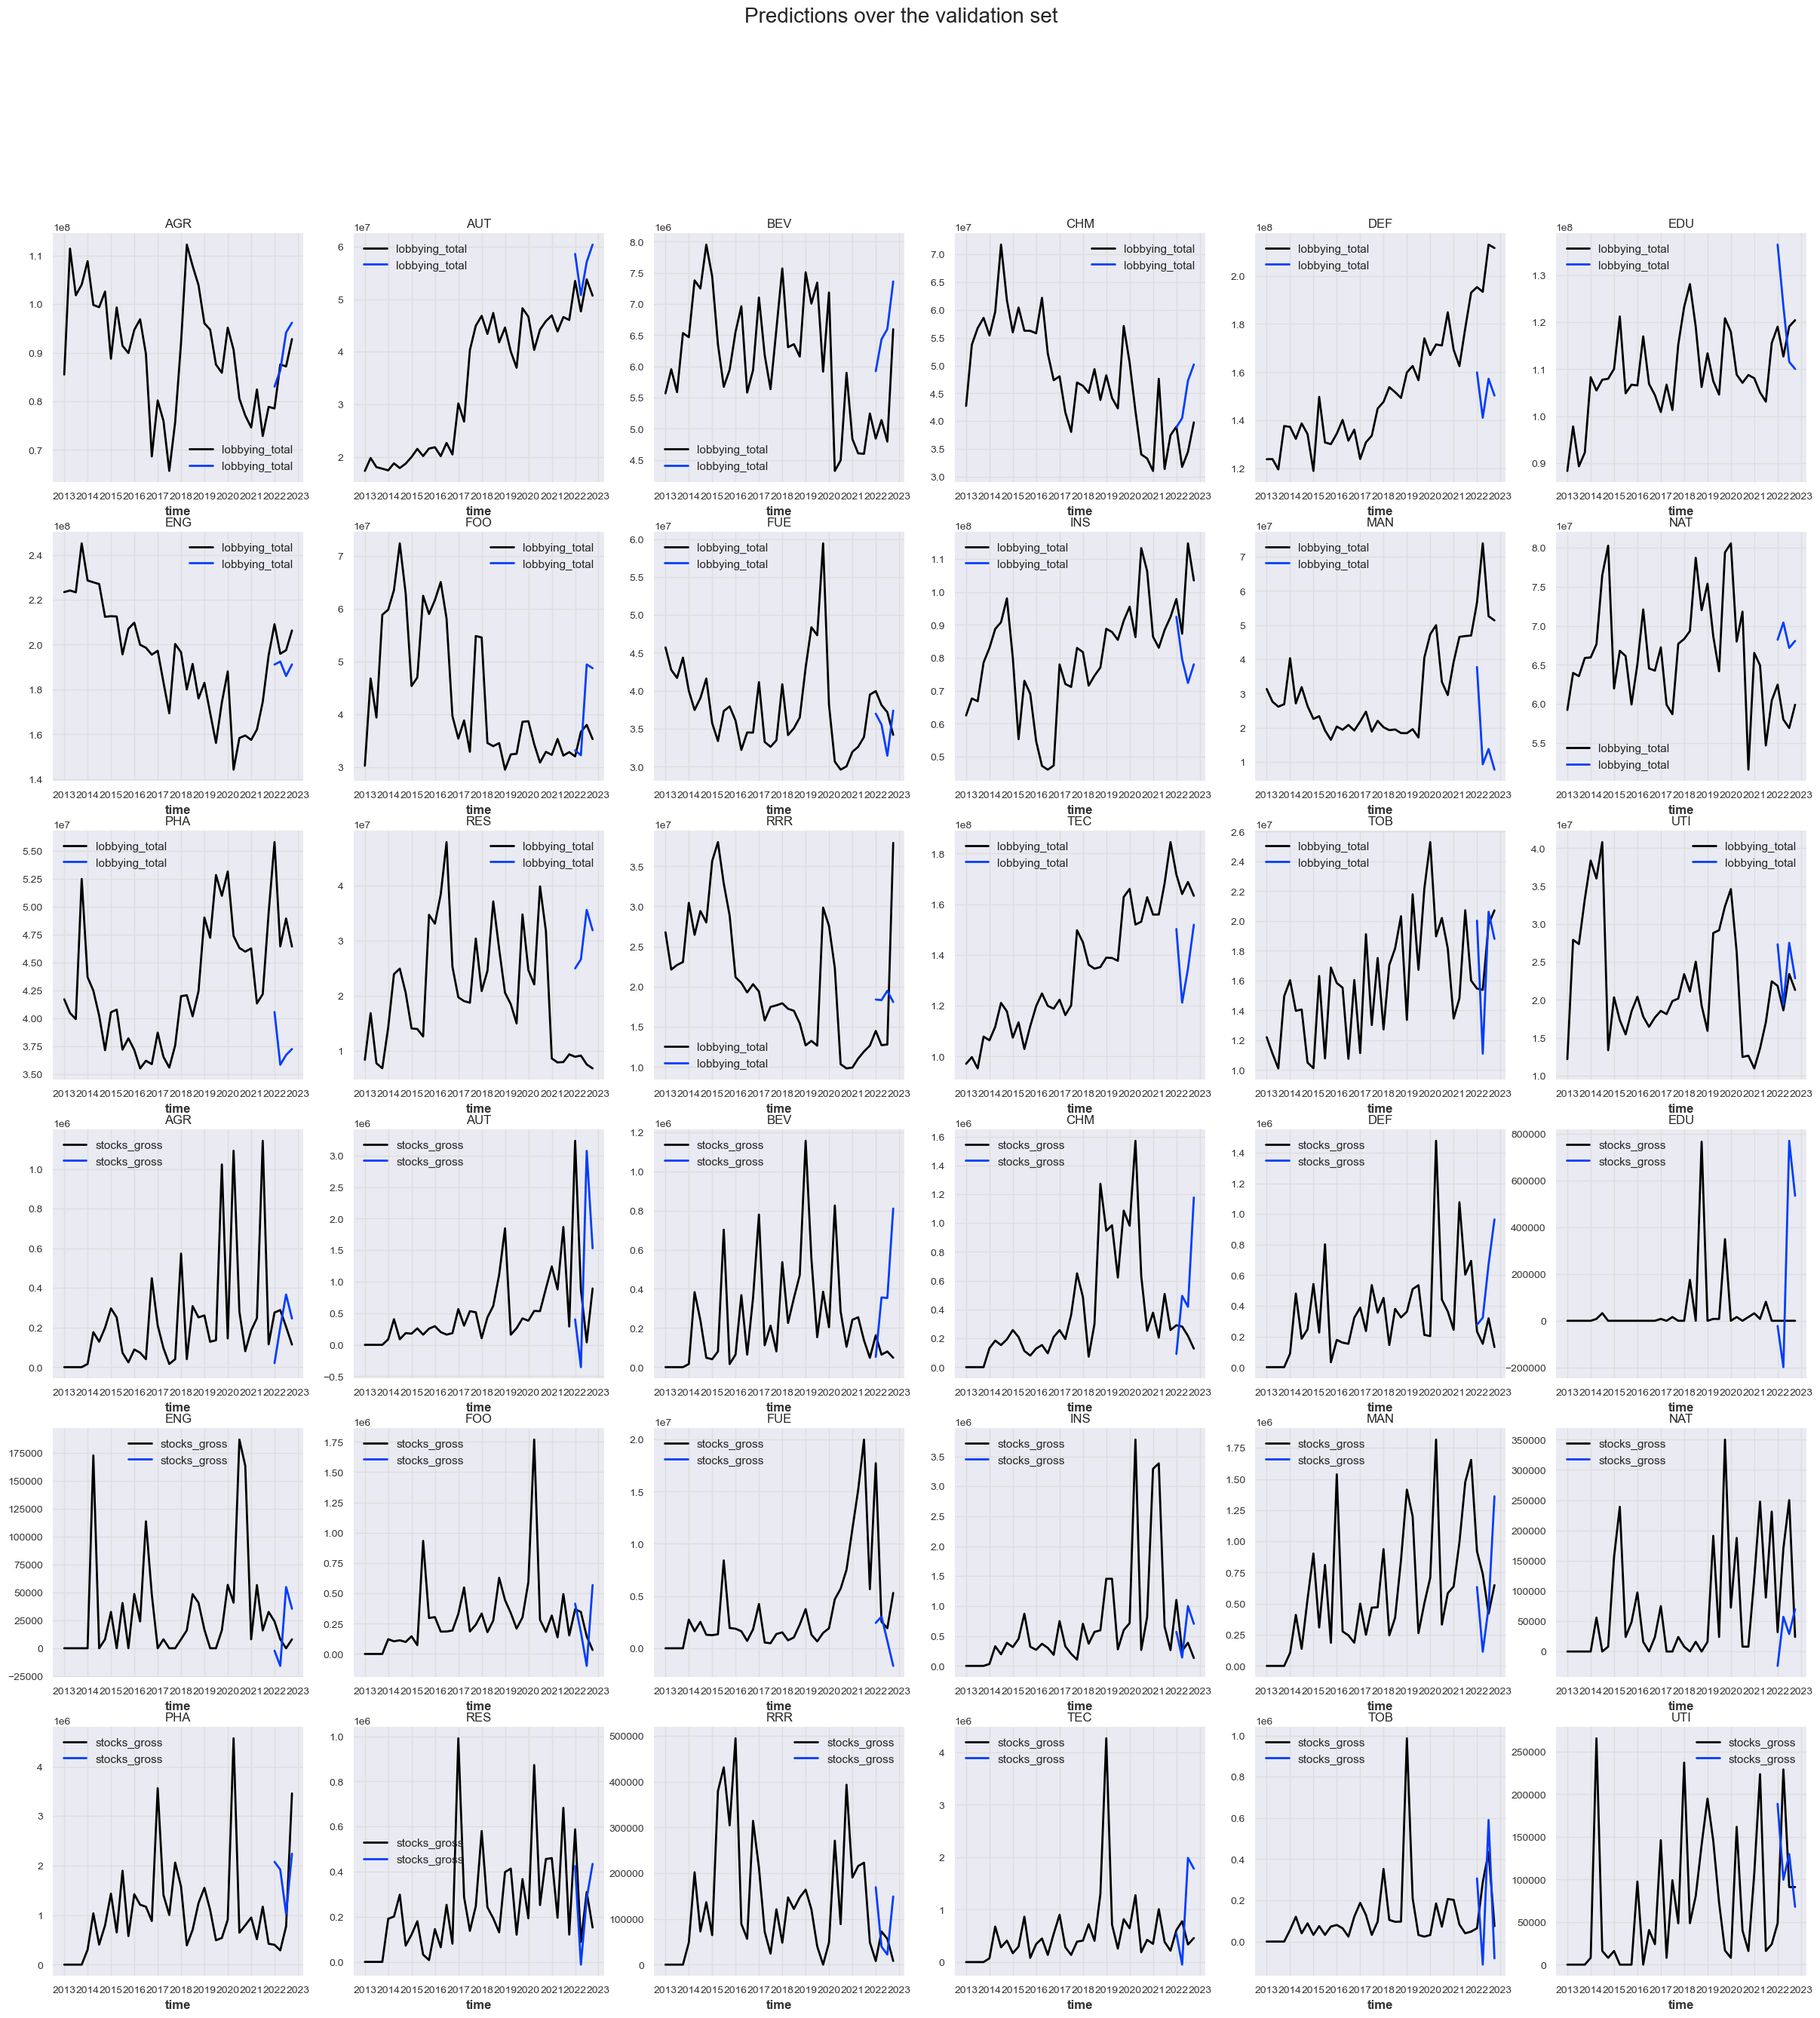

In [100]:
lobb_vars=['lobbying_total']
stocks_vars=['stocks_gross']
NBEATS_generic_performance=pd.DataFrame()
fig, axs = plt.subplots(6, 6, figsize=(30, 30))
axs=axs.flatten()
fig.suptitle('Predictions over the validation set', size=20)
for i, code in enumerate(cognates.keys()):
    pred, actual = predict(issue_code=code, model=NBEATS_generic)
    actual['lobbying_total'].plot(ax= axs[i])
    pred['lobbying_total'].plot(ax= axs[i])
    axs[i].set_title(code)
    actual['stocks_gross'].plot(ax= axs[i+18])
    pred['stocks_gross'].plot(ax= axs[i+18])
    axs[i+18].set_title(code)
    code_performance=[msse(actual[variable][-4:], pred[variable], actual[variable][:-4], m=1) for variable in lobb_vars+stocks_vars] #msse with 1-seasonality
    NBEATS_generic_performance[code]=code_performance
NBEATS_generic_performance.index=lobb_vars+stocks_vars
display(NBEATS_generic_performance)

In [101]:
NBEATS_generic_performance.sum(axis=1)

lobbying_total    114.614178
stocks_gross       46.794505
dtype: float64

Wow, that must be overfitting like crazy! It could definitely be improved by some early stopping, but we can try that when we do some tuning. I'm actually surprised its performance on stocks is in the same order or magnitude as the other models...

### (3) Cross validation and hyperparameter tuning

Here is a modified version of a cross-validation function from `scripts/model_evaluate.py`. We changed it to only use msse (with $m=1$) as the metric (msse has a slightly different syntax than many metrics in darts), but that's fine for our purposes here. msse, in our opinion, the best for model selection in our situation - it compares MSE of model prediction to true values over the validation with to that of the most naive baseline prediction, but in sample, and is scale invariant.

We also modified it to take in a Dataframe with columns as series, and added a scaling step before fitting.

In [62]:
def cross_validate(model, col, plot=True, test_size=4, n_cv=5):
    """Cross-validate a model across a time-series split, and optionally plot
    forecasts.
    
    Args:
      model: Darts-style model to test -- needs to implement model.fit(data)
        and model.predict(n) for forecasting.
      col (pd.DataFrame): Dataframe of columns of time series data to fit on
      plot (bool, default True): whether to plot the series and model forecasts
        on validation data.
      test_size (int, default 4): Number of quarters of data to include in each
        validation set.
      n_cv (int, default 5): Number of validation sets to use.

      
    Returns:
      The score of the model across all validation splits.
    """
    kf = TimeSeriesSplit(n_cv, test_size=test_size)
    score = 0


    if plot:
        fig, ax = plt.subplots()
        sns.lineplot(col, ax=ax)
        forecast_line = mlines.Line2D([], [], color="gray", linestyle="dashed")
        true_line = mlines.Line2D([], [], color="gray", linestyle="solid")

    for train_idx, valid_idx in kf.split(col):
        col_train = TimeSeries.from_dataframe(col.iloc[train_idx])
        col_valid = TimeSeries.from_dataframe(col.iloc[valid_idx])
        scaler=Scaler()       #added scaling before fit and predict
        col_train_scaled=scaler.fit_transform(col_train)
        model.fit(col_train_scaled)
        y_pred_scaled = model.predict(test_size)
        y_pred=scaler.inverse_transform(y_pred_scaled) #unscaling predictions
        score += msse(col_valid, y_pred, col_train, m=1)

        if plot:
            y_pred.plot(linestyle="dashed", ax=ax)
            
    score = score / kf.get_n_splits() #avg msse over cross-validation
    
    if plot:
        ax.legend(labels = ["observed", "forecast"], handles=[true_line, forecast_line])
        ax.set_title(col.name + f": score {score:0.3e}")
        
    return score

#### Varima, revisited.

This is a stupid function that I call in the definition of `varima_gridsearch` below. I made it just to keep things straight in the code.

In [63]:
def sum_metric_codes(model_parameters):
    tot=0
    for code in model_parameters.keys():
        tot+= model_parameters[code][1]
    return tot



Here's a function that does hyperparameter gridsearch for VARIMA. There are some annoying restrictions/consequences of the smallness of each data set. Namely, because VARIMA will not work on fewer than 30 data points, we have to use a tiny test size (`test_size`=2) and only 3-fold cross validation in order to run this. It thus probably won't be that useful!

In [79]:
def varima_gridsearch(lobb_vars, stocks_vars, p_min=0, p_max=1, q_min=0, q_max=2):
    
  """
  Apply a gridsearch for a VARIMA model. Because of our choices in hyperparameter restrictions, this is a little different than usual.
  For each pair (p,d), we choose q=q(p,d,code) best for each code. Then, when evaluating each p and d, we sum over all issue codes the msses of the best VARIMA(p,d,q) model. 
  We use this measure to determine the best (p,d).

  Args:
    lobb_vars, stock_vars (list, str): lists or strings of column names of our lobbying data, eg. lobb_vars=['lobbying_expenses'], stock_vars=['stocks_gross']
    p_min, p_max (int): integers specifying the range [p_min,p_max] of "autocorrelation" p to search over
    q_min,q_max (int): integers specifying the range [q_min,q_max] of "moving average" q to search over
    
  Returns:
    A dictionary, where keys are issue codes, and values are the tuple describing the best fit model for the code (only q should vary), and the model score after cross-validation.
  """

  if isinstance(lobb_vars, str):
      lobb_vars = [lobb_vars]
  if isinstance(stocks_vars, str):
        stocks_vars = [stocks_vars]

  p_range=range(p_min, p_max+1)
  q_range=range(q_min, q_max+1)
  p_models=[] #this list will store a list of length len(p_range), containing, for each index p, the best (p,d) model
  for p in p_range:
    d_models=[] # this list will store, for a given p, a list of length 2 containing the best (p,d) models, d=0,1.
    for d in range(2):
      model_parameters=dict(zip(cognates.keys(), [None for item in cognates.keys()])) #initializing a dictionary that will store parameters and scores for the best fit models
      for code in model_parameters.keys():
        df=stock_and_lobbying_totals(code, cognates[code])[lobb_vars+stocks_vars]
        for q in q_range:
          model_score=cross_validate(model=VARIMA(p=p,d=d,q=q), col=df, plot=False, test_size=4, n_cv=5)
          if (model_parameters[code]==None) or (model_parameters[code][1]>model_score):
            model_parameters[code]=[(p,d,q), model_score]
      d_models.append(model_parameters.copy())
    best_d=np.argmax([sum_metric_codes(model) for model in d_models])
    best_d_model=d_models[best_d]
  p_models.append(best_d_model.copy())
  best_p=np.argmax([sum_metric_codes(model) for model in p_models])
  best_model=p_models[best_p]
  return best_model
                


Time for some hyperparameter selection.

##### 2 Variable Varima

We have to split up $p=0$ and $p=1$ separately, as VARIMA requires $p+q\geq 1$.

First, $p=0$.

In [98]:
lobb_vars=['lobbying_total']
stocks_vars=['stocks_gross']
varima_gridsearch(lobb_vars, stocks_vars, p_min=0, p_max=0, q_min=1, q_max=2)

/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/

{'AGR': [(0, 0, 1), 2.1303714309695003],
 'AUT': [(0, 0, 2), 27.084160864512597],
 'BEV': [(0, 0, 2), 0.577108925955096],
 'CHM': [(0, 0, 2), 1.0483901732044025],
 'DEF': [(0, 0, 2), 13.493021470805033],
 'EDU': [(0, 0, 2), 2.7030743282602203],
 'ENG': [(0, 0, 2), 5.078740911306803],
 'FOO': [(0, 0, 2), 0.2706786765329236],
 'FUE': [(0, 0, 2), 5.101141220934644],
 'INS': [(0, 0, 2), 6.181459038915334],
 'MAN': [(0, 0, 2), 9.029247323920565],
 'NAT': [(0, 0, 2), 1.1086114412797965],
 'PHA': [(0, 0, 2), 3.9556902516607337],
 'RES': [(0, 0, 1), 0.7414831004646202],
 'RRR': [(0, 0, 1), 3.3208771896357008],
 'TEC': [(0, 0, 2), 10.485034425752907],
 'TOB': [(0, 0, 1), 1.771941534198407],
 'UTI': [(0, 0, 1), 1.021705822303346]}

In [99]:
sum_metric_codes({'AGR': [(0, 0, 1), 2.1303714309695003],
 'AUT': [(0, 0, 2), 27.084160864512597],
 'BEV': [(0, 0, 2), 0.577108925955096],
 'CHM': [(0, 0, 2), 1.0483901732044025],
 'DEF': [(0, 0, 2), 13.493021470805033],
 'EDU': [(0, 0, 2), 2.7030743282602203],
 'ENG': [(0, 0, 2), 5.078740911306803],
 'FOO': [(0, 0, 2), 0.2706786765329236],
 'FUE': [(0, 0, 2), 5.101141220934644],
 'INS': [(0, 0, 2), 6.181459038915334],
 'MAN': [(0, 0, 2), 9.029247323920565],
 'NAT': [(0, 0, 2), 1.1086114412797965],
 'PHA': [(0, 0, 2), 3.9556902516607337],
 'RES': [(0, 0, 1), 0.7414831004646202],
 'RRR': [(0, 0, 1), 3.3208771896357008],
 'TEC': [(0, 0, 2), 10.485034425752907],
 'TOB': [(0, 0, 1), 1.771941534198407],
 'UTI': [(0, 0, 1), 1.021705822303346]})

95.10273813061262

Oof, that's bad. Let's try with $p=1$.

In [100]:
lobb_vars=['lobbying_total']
stocks_vars=['stocks_gross']
varima_gridsearch(lobb_vars, stocks_vars, p_min=1, p_max=1, q_min=0, q_max=2)

/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check

{'AGR': [(1, 0, 1), 0.7986800761251108],
 'AUT': [(1, 0, 0), 3.929747156036474],
 'BEV': [(1, 0, 2), 0.29957140903116636],
 'CHM': [(1, 0, 1), 0.3744373201200332],
 'DEF': [(1, 0, 1), 2.5169910328413088],
 'EDU': [(1, 0, 2), 0.43747712380446596],
 'ENG': [(1, 0, 0), 0.7636785944957377],
 'FOO': [(1, 0, 2), 0.13128915094443824],
 'FUE': [(1, 0, 2), 2.6236389367195874],
 'INS': [(1, 0, 0), 1.311633160386166],
 'MAN': [(1, 0, 0), 4.106905483285991],
 'NAT': [(1, 0, 1), 0.7145649100936913],
 'PHA': [(1, 0, 2), 1.2795637339964383],
 'RES': [(1, 0, 2), 0.4584961075430376],
 'RRR': [(1, 0, 1), 2.809308927842416],
 'TEC': [(1, 0, 1), 1.5697362204545737],
 'TOB': [(1, 0, 1), 0.44832263107115833],
 'UTI': [(1, 0, 0), 0.3873363512175118]}

In [101]:
sum_metric_codes({'AGR': [(1, 0, 1), 0.7986800761251108],
 'AUT': [(1, 0, 0), 3.929747156036474],
 'BEV': [(1, 0, 2), 0.29957140903116636],
 'CHM': [(1, 0, 1), 0.3744373201200332],
 'DEF': [(1, 0, 1), 2.5169910328413088],
 'EDU': [(1, 0, 2), 0.43747712380446596],
 'ENG': [(1, 0, 0), 0.7636785944957377],
 'FOO': [(1, 0, 2), 0.13128915094443824],
 'FUE': [(1, 0, 2), 2.6236389367195874],
 'INS': [(1, 0, 0), 1.311633160386166],
 'MAN': [(1, 0, 0), 4.106905483285991],
 'NAT': [(1, 0, 1), 0.7145649100936913],
 'PHA': [(1, 0, 2), 1.2795637339964383],
 'RES': [(1, 0, 2), 0.4584961075430376],
 'RRR': [(1, 0, 1), 2.809308927842416],
 'TEC': [(1, 0, 1), 1.5697362204545737],
 'TOB': [(1, 0, 1), 0.44832263107115833],
 'UTI': [(1, 0, 0), 0.3873363512175118]})

24.961378326009307

This is much better!

Let's try to find the best $d=1$ model. My gridsearch function ignored these, so we'll look by hand. We first try a $p=0, d=1$ model.

In [118]:

lobb_vars=['lobbying_total']
stocks_vars=['stocks_gross']
model_parameters_0_1=dict(zip(cognates.keys(), [None for item in cognates.keys()]))
for code in model_parameters_0_1.keys():
    df=stock_and_lobbying_totals(code, cognates[code])[lobb_vars+stocks_vars]
    for q in range(1,3):
        model_score=cross_validate(model=VARIMA(p=0,d=1,q=q), col=df, plot=False, test_size=4, n_cv=5)
        if (model_parameters_0_1[code]==None) or (model_parameters_0_1[code][1]>model_score):
            model_parameters_0_1[code]=[(0,1,q), model_score]
model_parameters_0_1


/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/

{'AGR': [(0, 1, 2), 2.824981334265499],
 'AUT': [(0, 1, 1), 3.817839236082773],
 'BEV': [(0, 1, 1), 1.1045284298757978],
 'CHM': [(0, 1, 1), 5.504245099772429],
 'DEF': [(0, 1, 1), 1.6501668747740212],
 'EDU': [(0, 1, 2), 123.97711489291058],
 'ENG': [(0, 1, 1), 1.6267573322591713],
 'FOO': [(0, 1, 1), 1.3489107820309088],
 'FUE': [(0, 1, 2), 7.350535786053037],
 'INS': [(0, 1, 2), 3.656126376315771],
 'MAN': [(0, 1, 1), 2.758133553723964],
 'NAT': [(0, 1, 2), 1.5337925476998058],
 'PHA': [(0, 1, 1), 1.9055891615679847],
 'RES': [(0, 1, 2), 0.8477569273523308],
 'RRR': [(0, 1, 1), 2.636603015717811],
 'TEC': [(0, 1, 1), 3.339778715526221],
 'TOB': [(0, 1, 1), 3.3740735606250043],
 'UTI': [(0, 1, 1), 0.8599236792260199]}

In [119]:
sum_metric_codes(model_parameters_0_1)

170.1168573057791

Interestingly, this did really badly on `EDU` and OK on everything else. `EDU` is a weird code - it doesn't have enough trading in it. Still worse than the $p=1,d=0$ model though, even eliminating `EDU`.

And a $p=1,d=1$ approach.

In [120]:

lobb_vars=['lobbying_total']
stocks_vars=['stocks_gross']
model_parameters_1_1=dict(zip(cognates.keys(), [None for item in cognates.keys()]))
for code in model_parameters_1_1.keys():
    df=stock_and_lobbying_totals(code, cognates[code])[lobb_vars+stocks_vars]
    for q in range(1,3):
        model_score=cross_validate(model=VARIMA(p=1,d=1,q=q), col=df, plot=False, test_size=4, n_cv=5)
        if (model_parameters_1_1[code]==None) or (model_parameters_1_1[code][1]>model_score):
            model_parameters_1_1[code]=[(1,1,q), model_score]
model_parameters_1_1

/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check

{'AGR': [(1, 1, 1), 3.5166252064532157],
 'AUT': [(1, 1, 2), 4.156562497284538],
 'BEV': [(1, 1, 1), 1.04799014444447],
 'CHM': [(1, 1, 1), 4.701442714171181],
 'DEF': [(1, 1, 1), 1.7879578959077314],
 'EDU': [(1, 1, 1), 123.46340828892157],
 'ENG': [(1, 1, 1), 1.800411547153966],
 'FOO': [(1, 1, 1), 1.6321678332609622],
 'FUE': [(1, 1, 2), 7.492760622824216],
 'INS': [(1, 1, 2), 3.8836047328366208],
 'MAN': [(1, 1, 1), 2.923562012236691],
 'NAT': [(1, 1, 2), 1.626025197806348],
 'PHA': [(1, 1, 1), 1.751791924839236],
 'RES': [(1, 1, 1), 1.0509367071848432],
 'RRR': [(1, 1, 2), 3.7803666650243826],
 'TEC': [(1, 1, 1), 3.4791473151740524],
 'TOB': [(1, 1, 1), 3.356691476629931],
 'UTI': [(1, 1, 1), 1.9417202894892494]}

In [121]:
sum_metric_codes(model_parameters_1_1)

173.3931730716432

##### 4 Variable Varima

I want to try running a four variable VARIMA model, with `lobbying_expenses`, `lobbying_income`, `stocks_sale`, and `stocks_purchase`. We'll try $p=0$ first.

In [102]:
lobb_vars=['lobbying_expenses','lobbying_income']
stocks_vars=['stocks_sale', 'stocks_purchase']
varima_gridsearch(lobb_vars, stocks_vars, p_min=0, p_max=0, q_min=1, q_max=2)

/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/

{'AGR': [(0, 0, 2), 10.219619439127783],
 'AUT': [(0, 0, 2), 30.388544707778493],
 'BEV': [(0, 0, 2), 6.245147161298402],
 'CHM': [(0, 0, 2), 1.033532500096255],
 'DEF': [(0, 0, 2), 30.719041272950346],
 'EDU': [(0, 0, 2), 5.934699524410656],
 'ENG': [(0, 0, 1), 21.357743014606204],
 'FOO': [(0, 0, 2), 2.587133515939678],
 'FUE': [(0, 0, 1), 7.580289146623535],
 'INS': [(0, 0, 1), 6.5501661974669005],
 'MAN': [(0, 0, 2), 25.937598930233985],
 'NAT': [(0, 0, 2), 7.006459576666633],
 'PHA': [(0, 0, 2), 14.336234037152224],
 'RES': [(0, 0, 2), 2.3420278293550396],
 'RRR': [(0, 0, 1), 2.91552087630807],
 'TEC': [(0, 0, 2), 19.900657628903925],
 'TOB': [(0, 0, 2), 8.940373315609092],
 'UTI': [(0, 0, 2), 10.718397740780839]}

In [103]:
sum_metric_codes({'AGR': [(0, 0, 2), 10.219619439127783],
 'AUT': [(0, 0, 2), 30.388544707778493],
 'BEV': [(0, 0, 2), 6.245147161298402],
 'CHM': [(0, 0, 2), 1.033532500096255],
 'DEF': [(0, 0, 2), 30.719041272950346],
 'EDU': [(0, 0, 2), 5.934699524410656],
 'ENG': [(0, 0, 1), 21.357743014606204],
 'FOO': [(0, 0, 2), 2.587133515939678],
 'FUE': [(0, 0, 1), 7.580289146623535],
 'INS': [(0, 0, 1), 6.5501661974669005],
 'MAN': [(0, 0, 2), 25.937598930233985],
 'NAT': [(0, 0, 2), 7.006459576666633],
 'PHA': [(0, 0, 2), 14.336234037152224],
 'RES': [(0, 0, 2), 2.3420278293550396],
 'RRR': [(0, 0, 1), 2.91552087630807],
 'TEC': [(0, 0, 2), 19.900657628903925],
 'TOB': [(0, 0, 2), 8.940373315609092],
 'UTI': [(0, 0, 2), 10.718397740780839]})

214.71318641530806

Interestingly, our 4D VARIMA gridsearch throws an error while fitting for $p=1$ and $0\leq q\leq 2$.

In [ ]:
#lobb_vars=['lobbying_expenses','lobbying_income']    Don't run this, it's a waste of time!
#stocks_vars=['stocks_sale', 'stocks_purchase']
#varima_gridsearch(lobb_vars, stocks_vars, p_min=1, p_max=1, q_min=0, q_max=2)

I think the reason is that the `EDU` code is causing errors in training. I am going to remove it from consideration for the time being.

In [129]:
no_edu=list(cognates.keys()).copy()
no_edu.remove('EDU')

In [131]:
lobb_vars=['lobbying_expenses', 'lobbying_income']
stocks_vars=['stocks_sale', 'stocks_purchase']
model_parameters_1_0=dict(zip(no_edu, [None for item in no_edu]))
for code in model_parameters_1_0.keys():
    df=stock_and_lobbying_totals(code, cognates[code])[lobb_vars+stocks_vars]
    for q in range(2):
        model_score=cross_validate(model=VARIMA(p=1,d=0,q=q), col=df, plot=False, test_size=4, n_cv=5)
        if (model_parameters_1_0[code]==None) or (model_parameters_1_0[code][1]>model_score):
            model_parameters_1_0[code]=[(1,0,q), model_score]
model_parameters_1_0

/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/

LinAlgError: LU decomposition error.

Hmm, that didn't fix it.

##### 4 Variable Varima with expenses seasonally differenced

One last thing to try for VARIMA. Since we believe expenses to be seasonal with period 4, we should try running a 4 variable VARIMA where we feed in seasonally differenced expenses as one component. I can think of no good reason this should make sense, but let's see if it helps anyways.

In [134]:
p_min=0
p_max=0
q_min=1
q_max=2

lobb_vars=['lobbying_expenses','lobbying_income']
stocks_vars=['stocks_sale', 'stocks_purchase']
p_range=range(p_min, p_max+1)
q_range=range(q_min, q_max+1)
p_models=[] #this list will store a list of length len(p_range), containing, for each index p, the best (p,d) model
for p in p_range:
    d_models=[] # this list will store, for a given p, a list of length 2 containing the best (p,d) models, d=0,1.
    for d in range(2):
        model_parameters=dict(zip(cognates.keys(), [None for item in cognates.keys()])) #initializing a dictionary that will store parameters and scores for the best fit models
        for code in model_parameters.keys():
            df=stock_and_lobbying_totals(code, cognates[code])[lobb_vars+stocks_vars]
            df['diff_expenses']=df['lobbying_expenses'].diff(4)
            df=df[5:]
            df=df[['diff_expenses','lobbying_income']+stocks_vars]
            for q in q_range:
                model_score=cross_validate(model=VARIMA(p=p,d=d,q=q), col=df, plot=False, test_size=4, n_cv=5)
                if (model_parameters[code]==None) or (model_parameters[code][1]>model_score):
                    model_parameters[code]=[(p,d,q), model_score]
        d_models.append(model_parameters.copy())
    best_d=np.argmax([sum_metric_codes(model) for model in d_models])
    best_d_model=d_models[best_d]
p_models.append(best_d_model.copy())
best_p=np.argmax([sum_metric_codes(model) for model in p_models])
best_model=p_models[best_p]


/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/

LinAlgError: Schur decomposition solver error.

It looks like this is cursed to not work. The fundamental problem is rearing it's ugly head - there is not enough data going in to fit these complicated 4 variable models uniquely.